In [ ]:
!pip install top2vec
!pip install top2vec[sentence_encoders] --use-deprecated=legacy-resolver
!pip install top2vec[sentence_transformers]
# !pip install plotly==5.2.1
# !pip install -U kaleido

In [ ]:
import json, os, re, time,regex
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from natsort import natsorted

In [ ]:
import seaborn as sns
import networkx as nx
import umap
import hdbscan

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#model = Top2Vec(documents= cleaned_docs, speed='learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', kmeans_args = {"n_clusters": 15, "init": "k-means++"})

In [ ]:
with open('/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/upnishads_texts/eknath_datalist.json', 'r') as f:
  data_dict = json.load(f)

In [ ]:
# data_list = []
# data_dict_new = {}
# def get_data_list(d):
#   for k, v in d.items():
#     x = "{}".format(k)
#     if isinstance(v, dict):
#       get_data_list(v)
#     else:
#       if len(k) < 3:
#         #doc_list = getdoc(v)
#         if len(v.strip().split()) > 3:
#           data_list.append(v)
# get_data_list(data_dict)
# len(data_list)

In [ ]:
def nested_dict_pairs_iterator(dict_obj):
    ''' This function accepts a nested dictionary as argument
        and iterate over all values of nested dictionaries
    '''
    # Iterate over all key-value pairs of dict argument
    for key, value in dict_obj.items():
        # Check if value is of dict type
        if isinstance(value, dict):
            # If value is dict then iterate over all its values
            for pair in  nested_dict_pairs_iterator(value):
                yield [key, *pair]
        else:
            # If value is not dict type then yield the value
            yield [key, value]
#Loop through all key-value pairs of a nested dictionary
data_dict_new = {}
for pair in nested_dict_pairs_iterator(data_dict):
    data_dict_new['-'.join(pair[:-1])] = pair[-1]
with open('/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/upanishads_clean/eknath_easwaran_upanishads.json', 'w') as fp:
  json.dump(data_dict_new, fp, indent = 4)

In [ ]:
# data_list_all = []
# def get_data_list_all(d):
#   for k, v in d.items():
#     if isinstance(v, dict):
#       get_data_list_all(v)
#     else:
#       if len(k) < 3 and not isinstance(v, list):
#         #doc_list = getdoc(v)
#         if len(v.strip().split()) > 3:
#           data_list_all.append(v)
#       else:
#         list_intro = get_list_intro(v)
#         data_list_all.extend(list_intro)
# get_data_list_all(data_dict)
# len(data_list_all)

In [ ]:
def get_list_intro(data, num_words = 100):
  res = []
  words = data.strip().split(" ")
  i = 0
  while(i < (len(words))):
    if (i+num_words) < len(words):
      res.append(" ".join(words[i:i+num_words]))
      i = i+num_words
    else:
      res.append(" ".join(words[i:]))
      i = i+num_words
  return res

def get_data_dict_no_intro(data_dict_new):
  '''
  - get the dictionary of all the upanishads and without including introduction
  '''
  data_dict_all = {}
  for key, value in data_dict_new.items():
    if ('intro' in key) or ('Afterword' in key):
      continue
    else:
      data_dict_all[key] = value
  return data_dict_all

def get_data_dict_all(data_dict_new):
  '''
  - get the dictionary of all the upanishads and introduction from new data dictionary
  - for intro 100 words is considered as 1 documents
  '''
  data_dict_all = {}
  for key, value in data_dict_new.items():
    if ('intro' in key) or ('Afterword' in key):
      list_intro = get_list_intro(value)
      for i, x in enumerate(list_intro):
        data_dict_all[key+'-'+str(i)] = x
    else:
      data_dict_all[key] = value
  return data_dict_all

def remove_stop_words(data):
  word_list = word_tokenize(data)
  stops = set(stopwords.words("english"))
  filtered_words = [word for word in word_list if word not in stops]
  return " ".join(filtered_words)

def clean(data):
  """
  Args:
  data: single sentence
  """
  data = re.sub(r'[^\x00-\x7f]',r'', data)
  data = data.replace('\x0c', '')
  data = data.replace('\x0d', '')
  data = data.replace('\f', '')
  data = data.replace('\n', ' ')
  data = re.sub('[V]{1,}[.].*?[)]', '', data)
  data = re.sub('[I]{1,}[.].*?[)]', '', data)
  data = re.sub('IV{1,}[.].*?[)]', '', data)
  data = re.sub('X{1,}[.].*?[)]', '', data)
  data = re.sub('M[.]N[.]', '', data)
  # data = re.sub('[.][ ][.][ ][.][ ][.]', '', data)
  # data = re.sub('[.][ ][.][ ][.]', '', data)
  # data = re.sub('[.][ ][.]', '', data)
  # remove all other symbols numbers and white spaces
  data = "".join([character if (character.isalpha() or character == "." or character ==" " or character == "\n") else " " for character in data])
  #remove extra spaces in the middle of the sentence
  data = data.replace('.', ' ')
  data = re.sub(" +", " ", data)
  #remove extra spaces in the beginning
  data = data.strip()
  data = data.lower()
  # data = remove_stop_words(data)
  return data
  
def get_upanishads_dict(data_dict):
  upanishads_dict = defaultdict(str)
  for key, value in data_dict.items():
    if not 'Afterword' in key:
      if not 'FOUR' in key:
        name = key.strip().split('-')[0]
        upanishads_dict[name] = upanishads_dict[name]+value+'\n'
      elif not 'intro' in key:
        name = key.strip().split('-')[1]
        name = name.strip().split(" ")[1]
        upanishads_dict[name] = upanishads_dict[name]+value+'\n'
  return upanishads_dict

def get_word_docs_counts_upanishad_wise(upanishads_dict):
  upan_words_num = {}
  upan_docs_num = {}
  for key, text in upanishads_dict.items():
    words = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
    upan_words_num[key] = len(words)
    #get num of docs
    upan_docs_num[key] = len(text.split('\n'))
  return upan_words_num, upan_docs_num

In [ ]:
data_dict_no_intro = get_data_dict_no_intro(data_dict_new)
data_list_no_intro = list(data_dict_no_intro.values())
data_dict_all = get_data_dict_all(data_dict_new)
data_list_all = list(data_dict_all.values())
print(len(data_list_no_intro), len(data_list_all))

708 880


In [ ]:
# re.findall('[.][ ][.][ ][.][ ][.]', '\n'.join(data_list_all))

In [ ]:
cleaned_data_dict = {}
for key, value in data_dict_all.items():
  cleaned_data_dict[key] = clean(value)

with open('/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/upanishads_clean/eknath_easwaran_upanishads_cleaned.json', 'w') as fp:
  json.dump(cleaned_data_dict, fp, indent = 4)
# cleaned_data_dict

In [ ]:
# def get_upanishads_dict(data_dict):
#   upanishads_dict = defaultdict(str)
#   for key, value in data_dict.items():
#     if not 'Afterword' in key:
#       if not 'FOUR' in key:
#         name = key.strip().split('-')[0]
#         upanishads_dict[name] = upanishads_dict[name]+value+'\n'
#       elif not 'intro' in key:
#         name = key.strip().split('-')[1]
#         name = name.strip().split(" ")[1]
#         upanishads_dict[name] = upanishads_dict[name]+value+'\n'
#   return upanishads_dict

# def get_word_docs_counts_upanishad_wise(upanishads_dict):
#   upan_words_num = {}
#   upan_docs_num = {}
#   for key, text in upanishads_dict.items():
#     words = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
#     upan_words_num[key] = len(words)
#     #get num of docs
#     upan_docs_num[key] = len(text.split('\n'))
#   return upan_words_num, upan_docs_num

In [ ]:
import pprint

In [ ]:
upanishads_dict = get_upanishads_dict(cleaned_data_dict)
upan_words_num, upan_docs_num = get_word_docs_counts_upanishad_wise(upanishads_dict)
upanishads_dict_no_intro = get_upanishads_dict(data_dict_no_intro)
_, upan_verse_num = get_word_docs_counts_upanishad_wise(upanishads_dict_no_intro)

In [ ]:
pprint.pprint((upan_words_num, upan_docs_num,upan_verse_num))

({'AITAREYA': 743,
  'Amritabindu': 190,
  'Atma': 146,
  'BRIHADARANYAKA': 1894,
  'CHANDOGYA': 2696,
  'ISHA': 477,
  'KATHA': 2375,
  'KENA': 626,
  'MANDUKYA': 452,
  'MUNDAKA': 1133,
  'PRASHNA': 1313,
  'Paramahamsa': 182,
  'SHVESTASHVATARA': 1799,
  'TAITTIRIYA': 1657,
  'Tejobindu': 143},
 {'AITAREYA': 39,
  'Amritabindu': 23,
  'Atma': 4,
  'BRIHADARANYAKA': 69,
  'CHANDOGYA': 126,
  'ISHA': 20,
  'KATHA': 129,
  'KENA': 41,
  'MANDUKYA': 19,
  'MUNDAKA': 68,
  'PRASHNA': 72,
  'Paramahamsa': 5,
  'SHVESTASHVATARA': 116,
  'TAITTIRIYA': 54,
  'Tejobindu': 6},
 {'AITAREYA': 34,
  'Amritabindu': 23,
  'Atma': 4,
  'BRIHADARANYAKA': 62,
  'CHANDOGYA': 119,
  'ISHA': 64,
  'KATHA': 118,
  'KENA': 52,
  'MANDUKYA': 13,
  'MUNDAKA': 62,
  'PRASHNA': 67,
  'Paramahamsa': 5,
  'SHVESTASHVATARA': 111,
  'TAITTIRIYA': 49,
  'Tejobindu': 6})


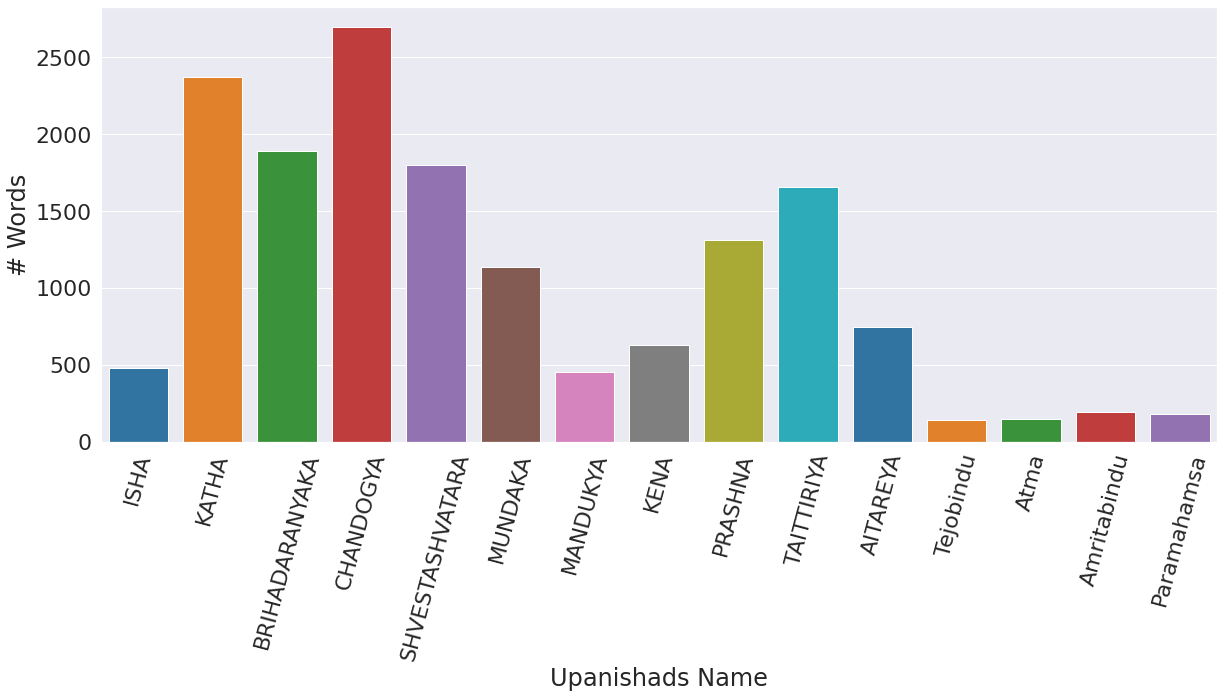

In [ ]:
sns.set(font_scale=2)
words_num_dict = {'Upanishads':[key for key in upan_words_num.keys()], '# Words':list(upan_words_num.values())}
df_words_num = pd.DataFrame(words_num_dict)
x_tick = [key for key in upan_words_num.keys()]
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num, palette='tab10')
# ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
_ = ax.set_xticklabels(x_tick, rotation=75)
plt.xlabel("Upanishads Name")
plt.savefig("/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/word_count_eknath_upanishads.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

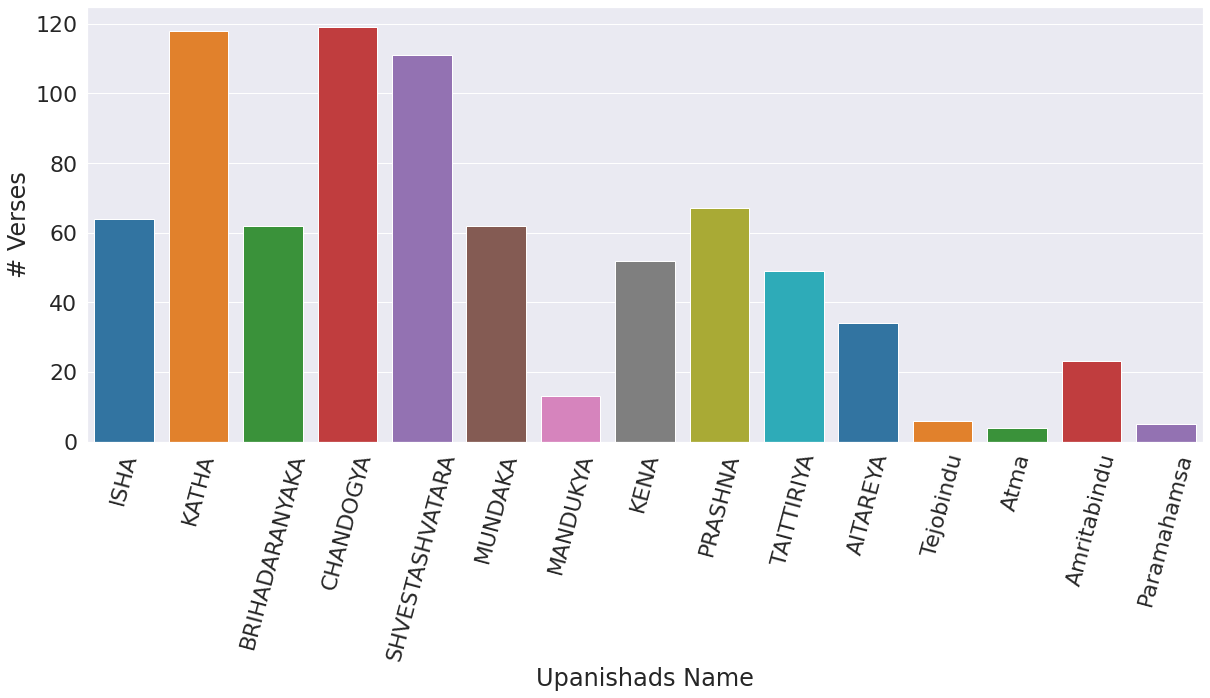

In [ ]:
sns.set()
sns.set(font_scale=2)
words_num_dict = {'Upanishads':[key for key in upan_verse_num.keys()], "# Verses":list(upan_verse_num.values())}
df_verse_num = pd.DataFrame(words_num_dict)
x_tick = [key for key in upan_verse_num.keys()]
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="Upanishads", y="# Verses", data=df_verse_num, palette='tab10')
# ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
_ = ax.set_xticklabels(x_tick, rotation=75)
plt.xlabel("Upanishads Name")
plt.savefig("/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/verse_count_eknath_upanishads.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
# cleaned_docs_upan = [clean(doc) for doc in data_list]
cleaned_docs_all_upan = [clean(doc) for doc in data_list_all]
# print(len(cleaned_docs_upan))
cleaned_docs_all_upan = [" ".join(word_tokenize(x)) for x in cleaned_docs_all_upan if (len(word_tokenize(x)) > 3)]
len(cleaned_docs_all_upan)

878

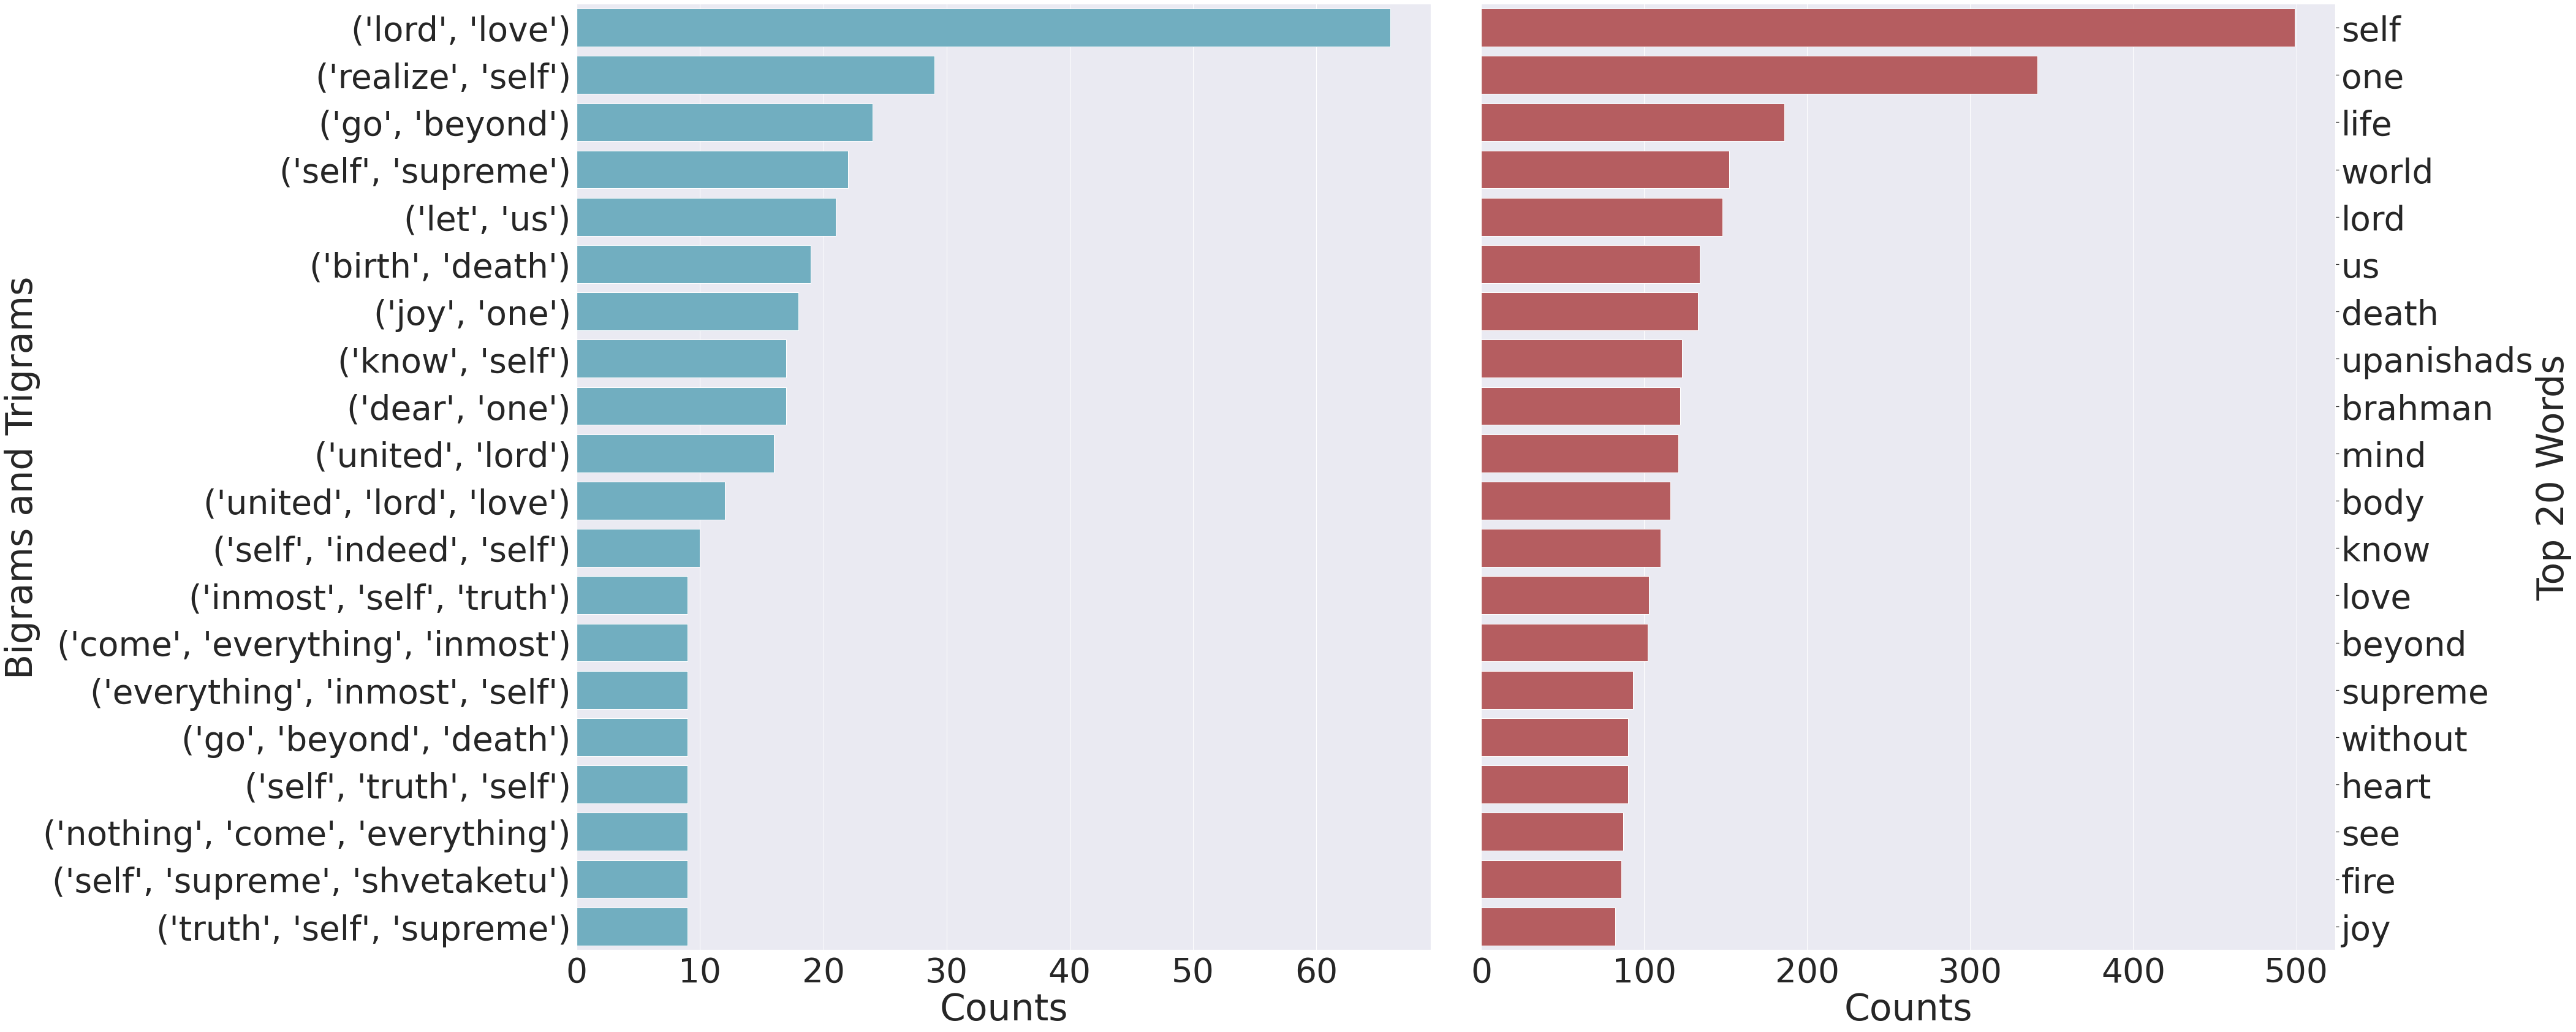

In [ ]:
def plot_uni_bi_trigram(cleaned_data_dict, file_name = "uni_bi_trigram_eknath_upanishads.pdf"):
  cleaned_text = '\n'.join(list(cleaned_data_dict.values()))
  cleaned_text = cleaned_text.lower()
  sns.set(font_scale=5)
  f, axs = plt.subplots(1,2,
                      figsize=(60,25),
                      gridspec_kw=dict(width_ratios=[1, 1]))
  stopwords_list = stopwords.words('english')
  stopwords_list.extend(['I', 'The', 'Him', 'He'])
  words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
  series_trigram = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]
  listbg1 = list(series_bigram.index)
  listbg2 = list(series_trigram.index)
  listtg1 = list(series_bigram.values)
  listtg2 = list(series_trigram.values)
  dict_ngram = {'Ngrams': listbg1+ listbg2, 
                'Counts': listtg1+ listtg2}
  df_ngram_count = pd.DataFrame(dict_ngram)
  # fig = plt.figure(figsize=(16, 8))
  # sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c", ax = axs[0])
  axs[0].set_xlabel("Counts")
  axs[0].set_ylabel("Bigrams and Trigrams")
  # plt.savefig("ngram_ten_upanishads.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

  # stopwords_list = stopwords.words('english')
  # stopwords_list.extend(['I', 'The', 'Him', 'He'])
  # words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_unigram = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]
  df_unigram = pd.DataFrame({'Top 20 Words': [x[0] for x in series_unigram.index], 'Counts': series_unigram.values})
  # fig = plt.figure(figsize=(16, 8))
  
  axs[1].yaxis.tick_right()
  axs[1].yaxis.set_label_position("right")
  # axs[1].set_xlabel("Counts")
  axs[1].set_ylabel('Top 20 Words')
  # axs[1].title.set_position([4, 4])
  # axs[1].yaxis.labelpad = 25
  sns.barplot(x="Counts", y='Top 20 Words', data=df_unigram, color="r", ax=axs[1])
  sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c", ax = axs[0])
  axs[0].set_xlabel("Counts")
  axs[0].set_ylabel("Bigrams and Trigrams")
  # f.text(0.5, 0.04, "Counts of the Bi-gram Tri-gram and \n the top 20 words of the Ten Upanishads", ha='center')
  f.tight_layout()
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=f.get_facecolor(), edgecolor='none')
plot_uni_bi_trigram(cleaned_data_dict)

In [ ]:
def plot_ngram(cleaned_data_dict, file_name = "ngram_eknath_upanishads.pdf"):
  sns.set(font_scale=2)
  cleaned_text = '\n'.join(list(cleaned_data_dict.values()))
  cleaned_text = cleaned_text.lower()
  stopwords_list = stopwords.words('english')
  stopwords_list.extend(['I', 'The', 'Him', 'He'])
  words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
  series_trigram = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]
  listbg1 = list(series_bigram.index)
  listbg2 = list(series_trigram.index)
  listtg1 = list(series_bigram.values)
  listtg2 = list(series_trigram.values)
  dict_ngram = {'Ngrams': listbg1+ listbg2, 
                'Counts': listtg1+ listtg2}
  df_ngram_count = pd.DataFrame(dict_ngram)
  fig = plt.figure(figsize=(16, 8))
  ax = sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c")
  plt.xlabel("Counts")
  plt.ylabel("Bigrams and Trigrams")
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
# plot_ngram(cleaned_data_dict)

In [ ]:
def plot_unigram(cleaned_data_dict, file_name = "unigram_eknath_upanishads.pdf"):
  sns.set(font_scale=2)
  cleaned_text = '\n'.join(list(cleaned_data_dict.values()))
  cleaned_text = cleaned_text.lower()
  stopwords_list = stopwords.words('english')
  stopwords_list.extend(['I', 'The', 'Him', 'He'])
  words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_unigram = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]
  df_unigram = pd.DataFrame({'Top 20 Words': [x[0] for x in series_unigram.index], 'Counts': series_unigram.values})
  fig = plt.figure(figsize=(16, 8))
  ax = sns.barplot(x="Counts", y='Top 20 Words', data=df_unigram, color="r")
  plt.xlabel("Counts")
  plt.ylabel('Top 20 Words')
  ax.yaxis.set_label_position("right")
  ax.yaxis.tick_right()
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
# plot_unigram(cleaned_data_dict)

## Bhagavad Geeta Analysis

In [ ]:
path = '/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/gita_cleaned/verses_eknath_easwaran.txt'
with open(path, 'r') as f:
  data_gita = f.read()

In [ ]:
def get_chapter_dict(data_gita):
  chapter_dict = defaultdict(str)
  chapter_gita_list = data_gita.split("\n\n")
  for chapter in chapter_gita_list:
    chapter_text_list = chapter.strip().split('\n')
    chapter_dict[chapter_text_list[0]] = '\n'.join(chapter_text_list[1:])
  return chapter_dict

def get_word_docs_counts_chapter_wise(data_gita):
  gita_words_num = {}
  gita_docs_num = {}
  chapter_dict = get_chapter_dict(data_gita)
  for key, text in chapter_dict.items():
    words = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
    gita_words_num[key] = len(words)
    #get num of docs
    gita_docs_num[key] = len(text.split('\n'))
  return gita_words_num, gita_docs_num
gita_words_num, gita_docs_num = get_word_docs_counts_chapter_wise(data_gita)
# gita_words_num, gita_docs_num

In [ ]:
pprint.pprint((gita_words_num, gita_docs_num))

({'Chapter 1': 796,
  'Chapter 10': 840,
  'Chapter 11': 1119,
  'Chapter 12': 324,
  'Chapter 13': 592,
  'Chapter 14': 448,
  'Chapter 15': 364,
  'Chapter 16': 468,
  'Chapter 17': 507,
  'Chapter 18': 1285,
  'Chapter 2': 1304,
  'Chapter 3': 751,
  'Chapter 4': 745,
  'Chapter 5': 540,
  'Chapter 6': 823,
  'Chapter 7': 549,
  'Chapter 8': 513,
  'Chapter 9': 627},
 {'Chapter 1': 47,
  'Chapter 10': 42,
  'Chapter 11': 55,
  'Chapter 12': 20,
  'Chapter 13': 34,
  'Chapter 14': 27,
  'Chapter 15': 20,
  'Chapter 16': 24,
  'Chapter 17': 28,
  'Chapter 18': 78,
  'Chapter 2': 72,
  'Chapter 3': 43,
  'Chapter 4': 42,
  'Chapter 5': 29,
  'Chapter 6': 47,
  'Chapter 7': 30,
  'Chapter 8': 28,
  'Chapter 9': 34})


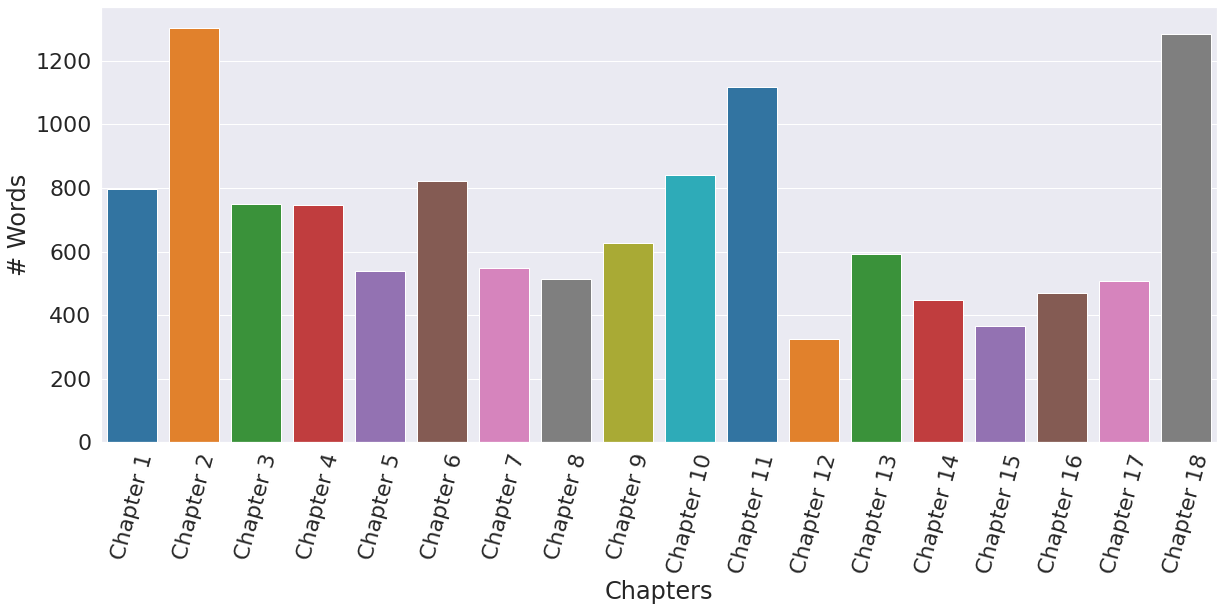

In [ ]:
sns.set(font_scale=2)
words_num_dict = {'Chapters':[key for key in gita_words_num.keys()], '# Words':list(gita_words_num.values())}
df_words_num = pd.DataFrame(words_num_dict)
x_tick = [key for key in gita_words_num.keys()]
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="Chapters", y="# Words", data=df_words_num, palette='tab10')
# ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
_ = ax.set_xticklabels(x_tick, rotation=75)
plt.xlabel("Chapters")
plt.savefig("word_count_eknath_gita.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

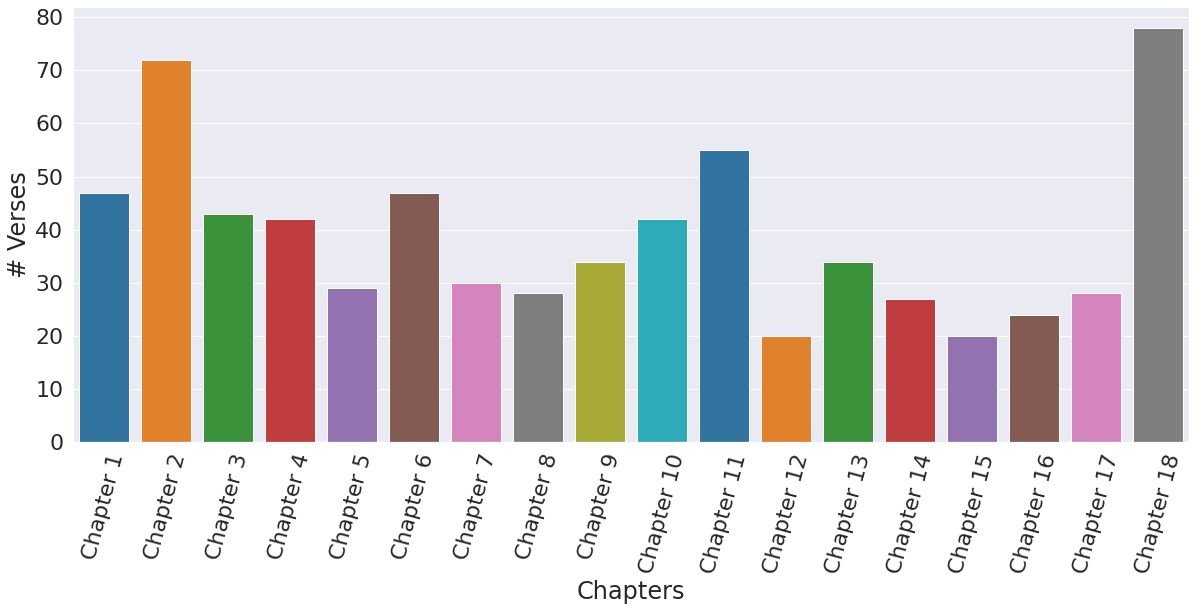

In [ ]:
sns.set()
sns.set(font_scale=2)
words_num_dict = {'Chapters':[key for key in gita_docs_num.keys()], '# Verses':list(gita_docs_num.values())}
df_words_num = pd.DataFrame(words_num_dict)
x_tick = [key for key in gita_docs_num.keys()]
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="Chapters", y="# Verses", data=df_words_num, palette='tab10')
# ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
_ = ax.set_xticklabels(x_tick, rotation=75)
plt.xlabel("Chapters")
plt.savefig("verses_count_eknath_gita.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

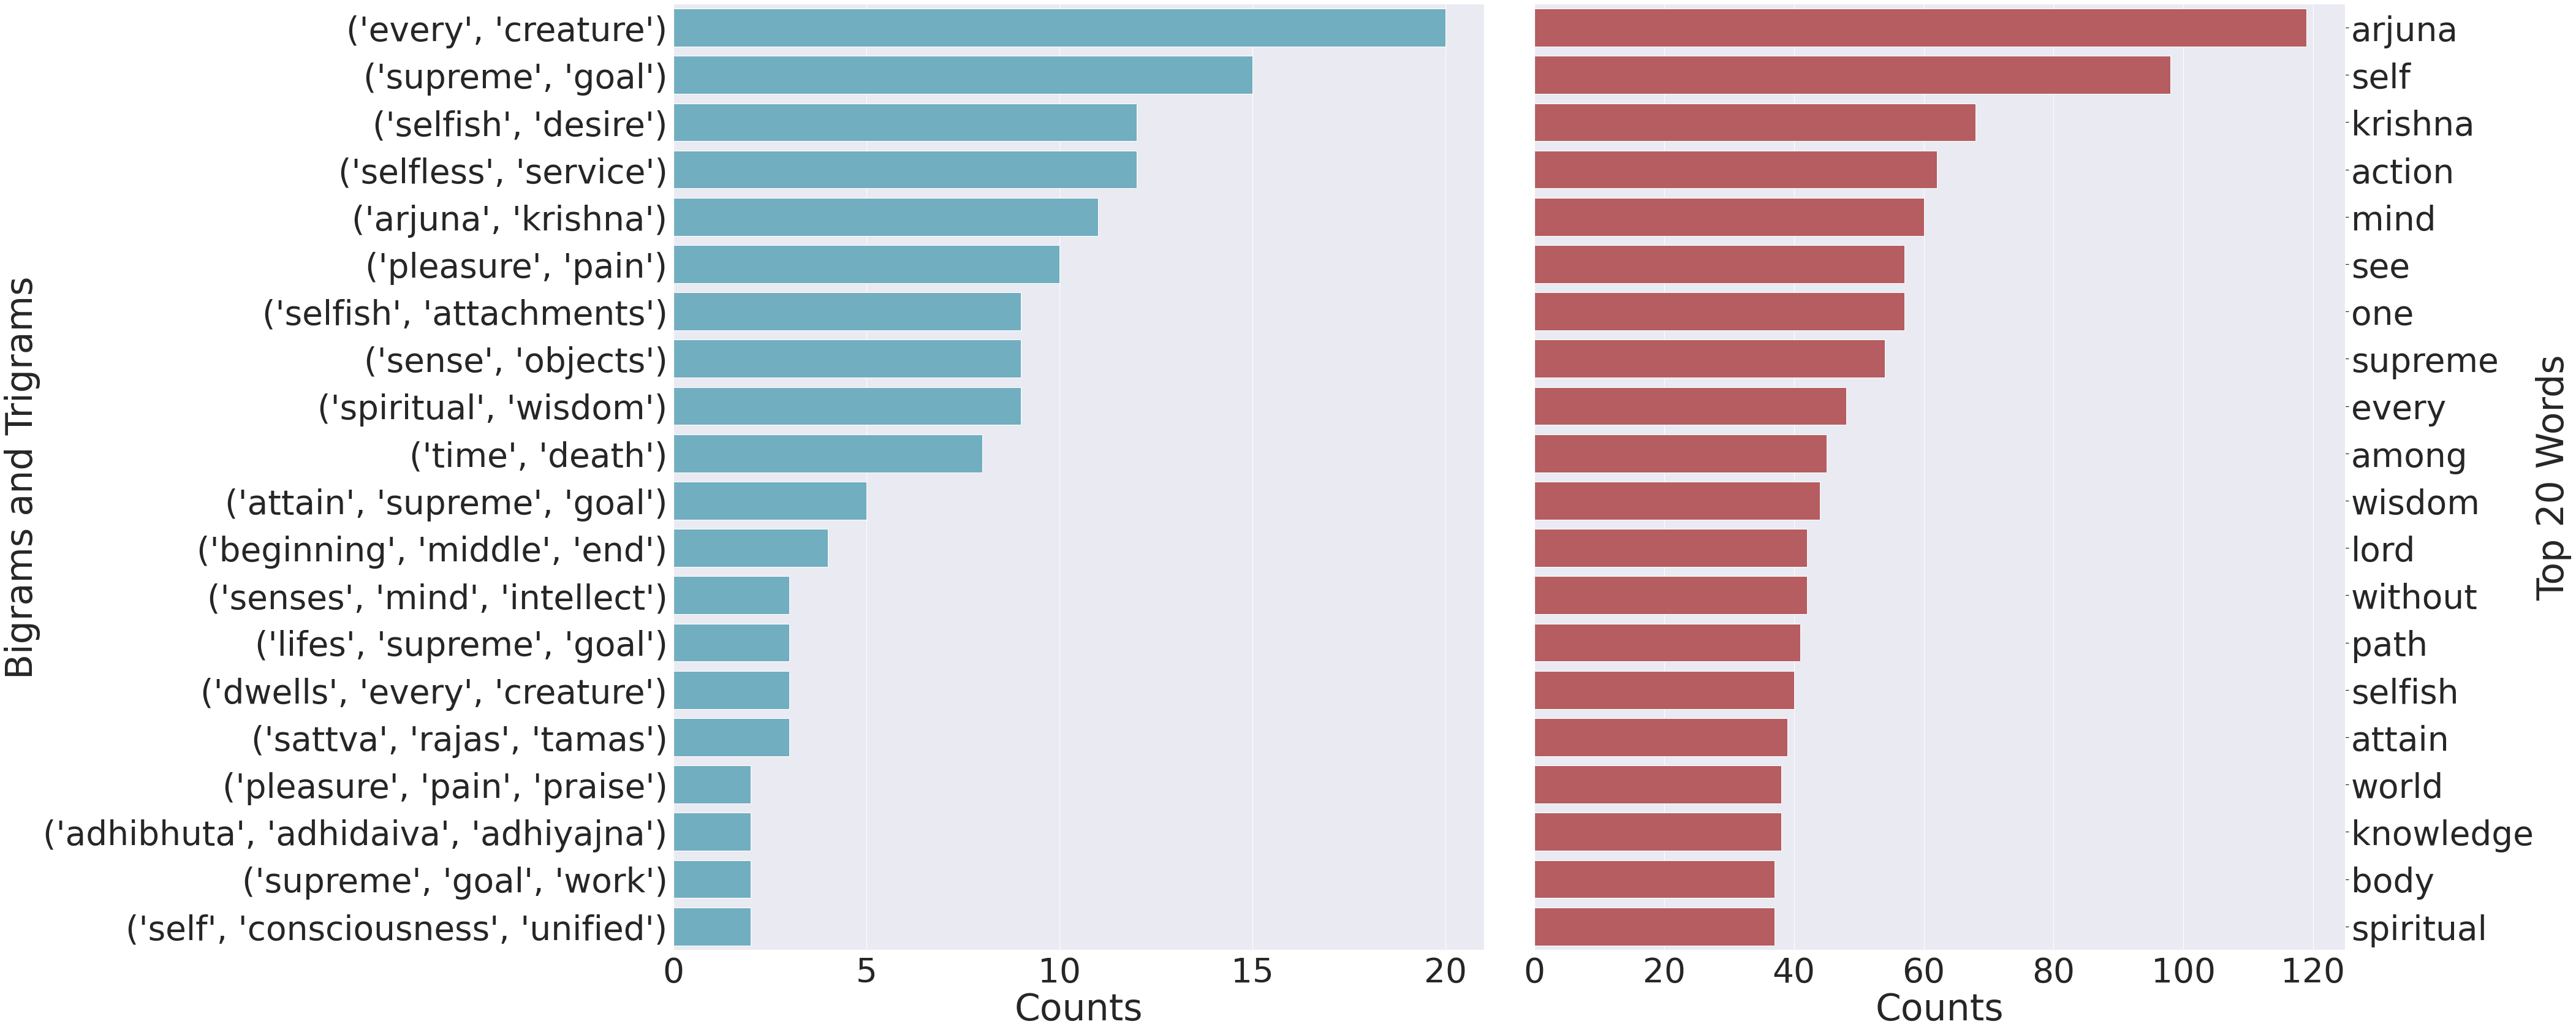

In [ ]:
chapter_dict = get_chapter_dict(data_gita)
cleaned_chapter_dict = {x:remove_stop_words(clean(y).lower()) for x, y in chapter_dict.items()}
# plot_unigram(cleaned_chapter_dict, file_name = "unigram_eknath_gita.pdf")
# plot_ngram(cleaned_chapter_dict, file_name = "ngram_eknath_gita.pdf")
plot_uni_bi_trigram(cleaned_chapter_dict, file_name = "uni_bi_trigram_eknath_gita.pdf")

## Ten Upanishads Analysis

In [ ]:
data_path = '/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/upanishads_clean/cleaned_ten_principal_upanishad.txt'
with open(data_path, 'r') as f:
  data_ten_u = f.read()

In [ ]:
def get_upanishad_names(data):
  paragraphs = data.split('\n')
  upan_names = {}
  for i, x in enumerate(paragraphs):
    t = re.findall(r'[(].*Upanishad[)]', x)
    if t:
      upan_names[t[0][1:-1]] = i
  return upan_names

def get_text_upanishad_wise(data):
  upan_names = get_upanishad_names(data)
  paragraphs = data.split('\n')
  upan_text = {}
  idx_list = list(upan_names.values())
  name_list = list(upan_names.keys())
  for idx, name in enumerate(name_list):
    if idx < len(idx_list)-1:
      upan_text[name] = '\n'.join(paragraphs[idx_list[idx]+1:idx_list[idx+1]])
    else:
      upan_text[name] = '\n'.join(paragraphs[idx_list[idx]+1:-1])
  return upan_text

def get_num_words_docs_upanishad_wise(data):

  upan_text = get_text_upanishad_wise(data)
  name_list = list(upan_text.keys())
  text_list = list(upan_text.values())
  upan_words_num = {}
  upan_docs_num = {}
  for idx, text in enumerate(text_list):
    # remove numbers and chapter divider like Book I, Book II etc
    text = re.sub('Book.*\n', '', text)
    text = re.sub('[0-9]+', '', text)
    #remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    #get words and remove stopwords
    words = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
    upan_words_num[name_list[idx]] = len(words)
    #get num of docs
    upan_docs_num[name_list[idx]] = len(text.split('\n'))

  return upan_words_num, upan_docs_num

def plot_word_count(upan_words_num, file_name = "word_count_ten_upanishads.pdf", xlabel = "Upanishads Name", ylabel = "# Words"):
  sns.set(font_scale=2)
  words_num_dict = {'Upanishads':[x.strip().split('-')[0] for x in upan_words_num.keys()], '# Words':list(upan_words_num.values())}
  df_words_num = pd.DataFrame(words_num_dict)
  x_tick = [x.strip().split('-')[0] for x in upan_words_num.keys()]
  fig = plt.figure(figsize=(16, 8))
  ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
  # ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
  _ = ax.set_xticklabels(x_tick, rotation=45)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

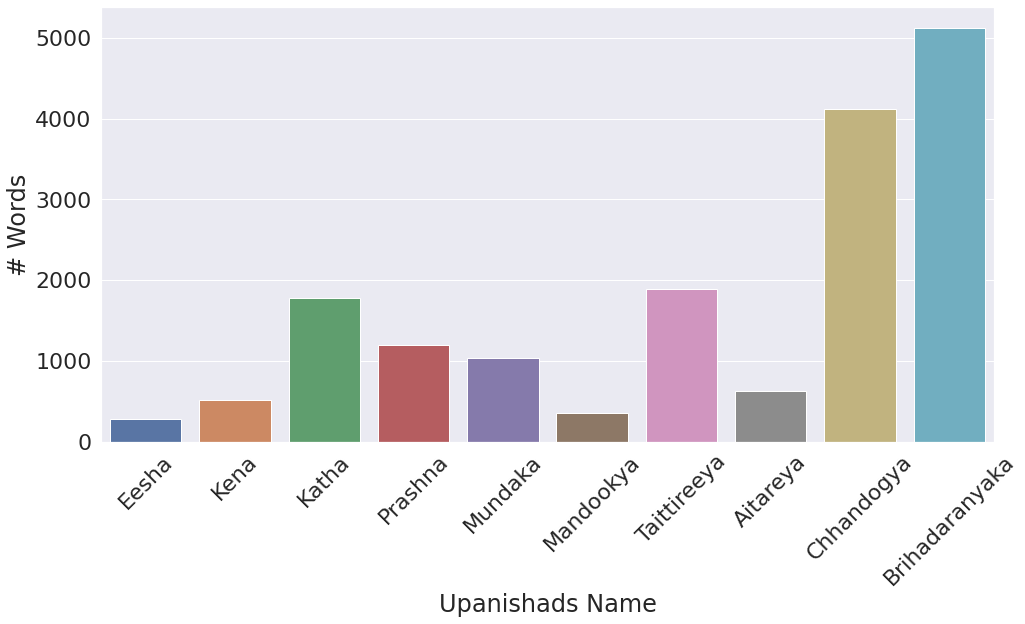

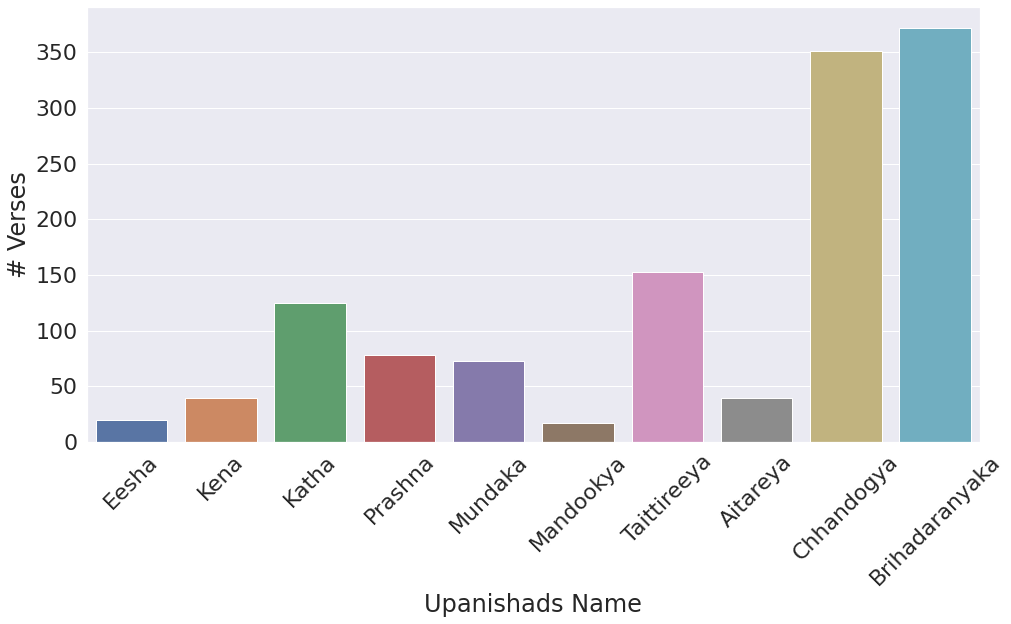

In [ ]:
upan_words_num, upan_docs_num = get_num_words_docs_upanishad_wise(data_ten_u)
plot_word_count(upan_words_num)
plot_word_count(upan_docs_num, file_name = "verses_count_ten_upanishads.pdf", xlabel = "Upanishads Name", ylabel = "# Verses")

In [ ]:
pprint.pprint((upan_words_num, upan_docs_num))

({'Aitareya-Upanishad': 632,
  'Brihadaranyaka-Upanishad': 5125,
  'Chhandogya-Upanishad': 4121,
  'Eesha-Upanishad': 286,
  'Katha-Upanishad': 1783,
  'Kena-Upanishad': 522,
  'Mandookya-Upanishad': 356,
  'Mundaka-Upanishad': 1034,
  'Prashna-Upanishad': 1201,
  'Taittireeya-Upanishad': 1894},
 {'Aitareya-Upanishad': 39,
  'Brihadaranyaka-Upanishad': 372,
  'Chhandogya-Upanishad': 351,
  'Eesha-Upanishad': 20,
  'Katha-Upanishad': 125,
  'Kena-Upanishad': 39,
  'Mandookya-Upanishad': 17,
  'Mundaka-Upanishad': 73,
  'Prashna-Upanishad': 78,
  'Taittireeya-Upanishad': 153})


In [ ]:
num_docs = sum(upan_docs_num.values())
num_words = sum(upan_words_num.values())
print(num_docs, num_words)

1267 16954


In [ ]:
def basic_clean_tu(text):
  text = '\n'.join(list(get_text_upanishad_wise(text).values()))
  text = re.sub('Book.*\n', '', text)
  text = re.sub('[0-9]+', '', text)
  text = re.sub(r'[^\w\s]','',text)
  return text
text = basic_clean_tu(data_ten_u)
print(len(text.lower().split('\n')), len(text.strip().split(" ")))

1267 27492


In [ ]:
24492/1267

19.330702446724548

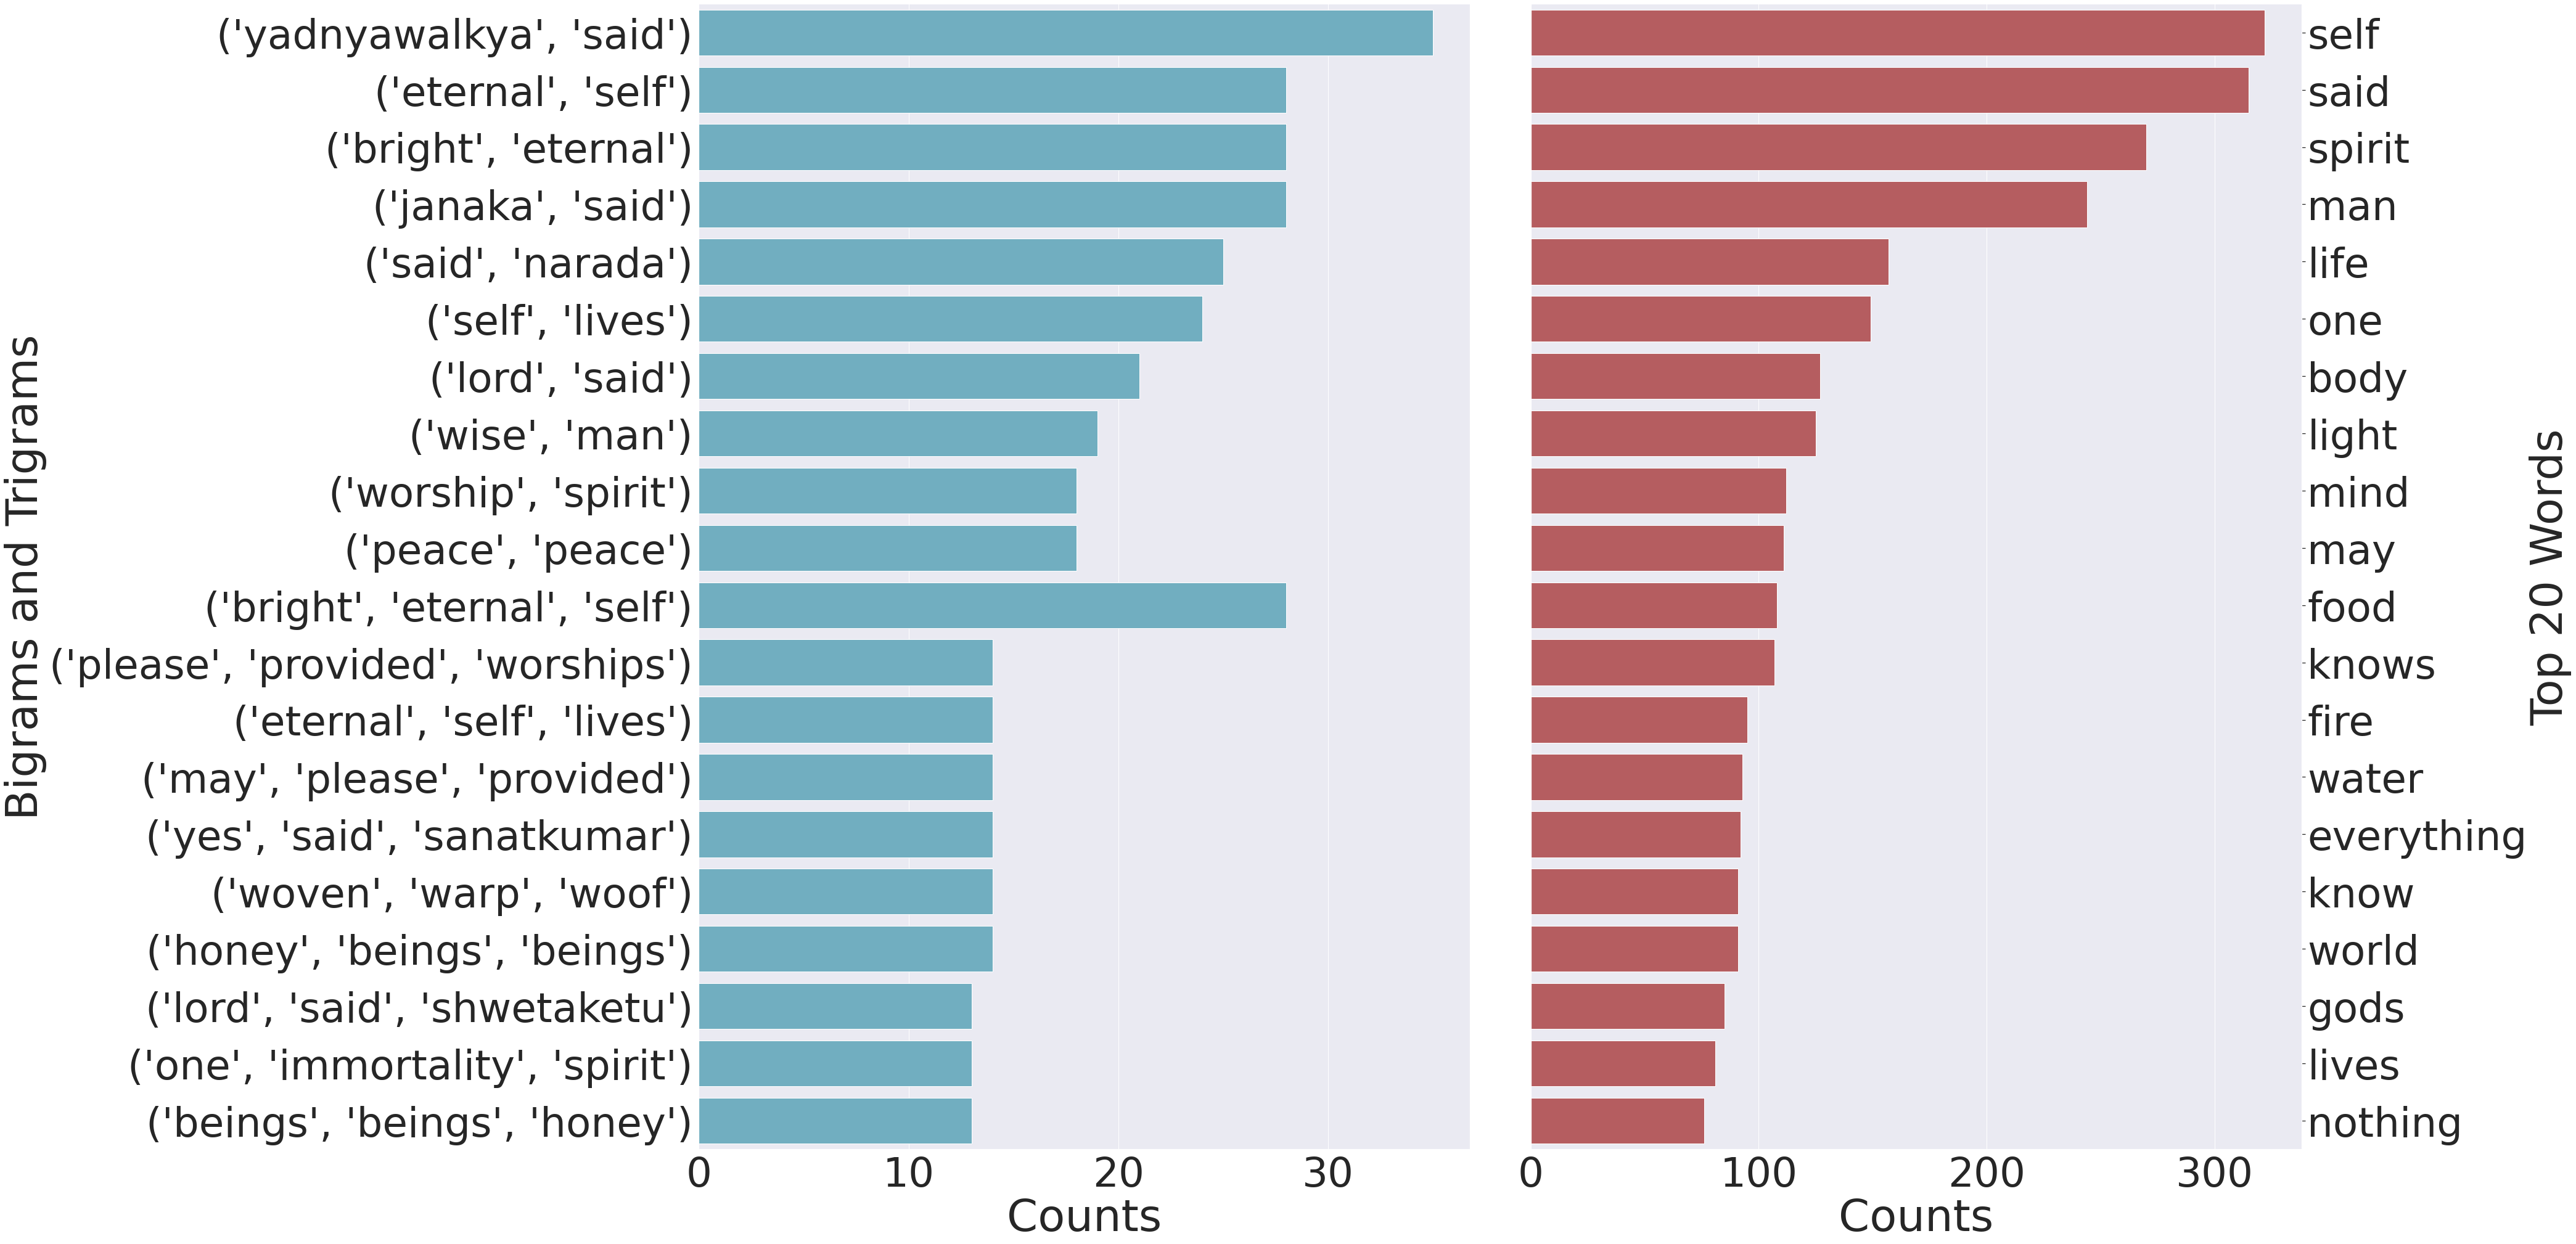

In [ ]:
def plot_ngram_upan(cleaned_text):
  sns.set(font_scale=6)
  f, axs = plt.subplots(1,2,
                      figsize=(60,30),
                      gridspec_kw=dict(width_ratios=[1, 1]))
  stopwords_list = stopwords.words('english')
  stopwords_list.extend(['I', 'The', 'Him', 'He'])
  words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
  series_trigram = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]
  listbg1 = list(series_bigram.index)
  listbg2 = list(series_trigram.index)
  listtg1 = list(series_bigram.values)
  listtg2 = list(series_trigram.values)
  dict_ngram = {'Ngrams': listbg1+ listbg2, 
                'Counts': listtg1+ listtg2}
  df_ngram_count = pd.DataFrame(dict_ngram)
  # fig = plt.figure(figsize=(16, 8))
  # sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c", ax = axs[0])
  axs[0].set_xlabel("Counts")
  axs[0].set_ylabel("Bigrams and Trigrams")
  # plt.savefig("ngram_ten_upanishads.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

  # stopwords_list = stopwords.words('english')
  # stopwords_list.extend(['I', 'The', 'Him', 'He'])
  # words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_unigram = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]
  df_unigram = pd.DataFrame({'Top 20 Words': [x[0] for x in series_unigram.index], 'Counts': series_unigram.values})
  # fig = plt.figure(figsize=(16, 8))
  
  axs[1].yaxis.tick_right()
  axs[1].yaxis.set_label_position("right")
  # axs[1].set_xlabel("Counts")
  axs[1].set_ylabel('Top 20 Words')
  # axs[1].title.set_position([4, 4])
  # axs[1].yaxis.labelpad = 25
  sns.barplot(x="Counts", y='Top 20 Words', data=df_unigram, color="r", ax=axs[1])
  sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c", ax = axs[0])
  axs[0].set_xlabel("Counts")
  axs[0].set_ylabel("Bigrams and Trigrams")
  # f.text(0.5, 0.04, "Counts of the Bi-gram Tri-gram and \n the top 20 words of the Ten Upanishads", ha='center')
  f.tight_layout()
  plt.savefig("uni_bi_trigram_ten_upanishads.pdf", bbox_inches = 'tight',dpi = 150, facecolor=f.get_facecolor(), edgecolor='none')
plot_ngram_upan(text.lower())

## Topics Eknath Upanishads

In [ ]:
def get_all_words(doc_list):
  token_lists = []
  for doc in doc_list:
    token_lists.append(word_tokenize(doc))
  return token_lists

def process_doc(doc_lists):
  token_lists = get_all_words(doc_lists)
  dictionary = corpora.Dictionary(token_lists)
  # convert tokenized documents into a document-term matrix
  corpus = [dictionary.doc2bow(text) for text in token_lists]

  return token_lists, dictionary, corpus

def get_coherence(model, token_lists, corpus, dictionary, method = 'top2vec', measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if method == 'LDA':
        cm = CoherenceModel(model = model, texts=token_lists, corpus= corpus, dictionary = dictionary,
                            coherence=measure)
    else:
        topics = model.topic_words
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus= corpus, dictionary = dictionary,
                            coherence=measure)
    return cm.get_coherence()
token_lists_u, dictionary_u, corpus_u = process_doc(cleaned_docs_all_upan)

In [ ]:
from topic_model import TopicModel

In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
model_use_upan = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)
model_sbert_upan = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, hdbscan_args = hdbscan_args)
print("###Coherence USE ##### No TOPIC USE")
print(get_coherence(model_use_upan, token_lists_u, corpus_u, dictionary_u), model_use_upan.get_num_topics())
print("###Coherence SBERT ##### No TOPIC SBERT")
print(get_coherence(model_sbert_upan, token_lists_u, corpus_u, dictionary_u), model_sbert_upan.get_num_topics())

2022-01-30 13:06:02,122 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-30 13:06:02,279 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2022-01-30 13:06:09,727 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-30 13:06:18,261 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is di

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2022-01-30 13:06:49,227 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-30 13:09:00,786 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-30 13:09:05,681 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-01-30 13:09:05,722 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


###Coherence USE ##### No TOPIC USE
0.6588744209878339 18
###Coherence SBERT ##### No TOPIC SBERT
0.6591885095867489 18


In [ ]:
# topic_words, word_scores, topic_nums = model.get_topics()
# topic_words
# for topic in topic_nums:
#   model.generate_topic_wordcloud(topic)

In [ ]:
# details = []
# for i in range(18):
#   details.append(model_use_upan.search_documents_by_topic(10, 15))
# details

In [ ]:
all_topics = []
def get_topic_dict(model, model_name = 'model_use_upan'):
  topic_words, word_scores, topic_nums = model.get_topics()
  topic_docs = []
  for i in range(model.get_num_topics()):
    topic_docs.append(list(model.search_documents_by_topic(i, min(15, model.topic_sizes[i]) )[0]))
  dict_top = {}
  #model_name, topics, score
  dict_top['model_name'] = model_name
  dict_top['topic_words'] = [{'topic_{}'.format(i+1): list(x)} for i, x in enumerate(topic_words)]
  dict_top['topic_docs'] = [{'topic_{}'.format(i+1): list(x)} for i, x in enumerate(topic_docs)]
  return dict_top
all_topics.append(get_topic_dict(model = model_use_upan, model_name = 'model_use_upan'))
all_topics.append(get_topic_dict(model = model_sbert_upan, model_name = 'model_sbert_upan'))
# print(all_topics)
# all_topics[0]['topic_docs'][0]['topic_1']
# model_use_upan.search_documents_by_topic(0, 15)[0]

In [ ]:
# umap_args = {
#       "n_neighbors": 10,
#       "n_components": 2, # 5 -> 2 for plotting 
#       "metric": "cosine",
#       "random_state":42
#       }

# umap_data = umap.UMAP(**umap_args).fit_transform(model._get_document_vectors(norm=False))
# hdbscan_args = {'min_cluster_size': 10,
#                 'min_samples':5,
#                 'metric': 'euclidean',
#                 'cluster_selection_method': 'eom',
#                 'gen_min_span_tree': True
#              }
# clusterer = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_data)
# np.unique(clusterer.labels_)

In [ ]:
# sns.set()
# fig = plt.figure(figsize=(20, 15))
# ax = fig.add_subplot(111)
# clusterer.minimum_spanning_tree_.plot(edge_cmap='rainbow',
#                                       node_size=200,
#                                       edge_linewidth=3,
#                                       axis = ax)
# fig = plt.figure(figsize=(46, 25))
# ax = fig.add_subplot(111)
# clusterer.single_linkage_tree_.plot(axis = ax,cmap = 'rainbow')

In [ ]:
# fig = plt.figure(figsize=(36, 25))
# ax = fig.add_subplot(111)
# clusterer.condensed_tree_.plot(axis = ax, select_clusters=True,
#                                selection_palette=sns.color_palette('deep', 18))

In [ ]:
# G = clusterer.condensed_tree_.to_networkx()
# print(G)

In [ ]:
# plt.figure(figsize=(36,36))
# nx.draw(G, connectionstyle='arc, rad = 0.05')

In [ ]:
# model.topic_words

In [ ]:
# model.search_documents_by_keywords(keywords=['gandhara'], num_docs=30)

## Bhagavad Gita

In [ ]:
path = '/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/gita_cleaned/verses_eknath_easwaran.txt'
with open(path, 'r') as f:
  data_gita = f.read()

In [ ]:
num_words_gita = len(word_tokenize(data_gita))
avg_words = num_words_gita/(len(data_gita.split("\n")))
print(num_words_gita, avg_words)

20296 27.61360544217687


In [ ]:
data_gita_list = data_gita.split("\n")
data_gita_list = [" ".join(word_tokenize(x)) for x in data_gita_list if 'Chapter' not in x and len(x) > 1]
 
data_gita_list = [clean(doc) for doc in data_gita_list]

In [ ]:
len(data_gita_list)

700

In [ ]:
token_lists_g, dictionary_g, corpus_g = process_doc(data_gita_list)

In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':4,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
# model_use_gita = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)
model_sbert_gita = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, hdbscan_args = hdbscan_args)
# print("###Coherence USE ##### #No TOPIC USE")
# print(get_coherence(model_use_gita, token_lists_g, corpus_g, dictionary_g), model_use_gita.get_num_topics())
print("###Coherence SBERT ##### #No TOPIC SBERT")
print(get_coherence(model_sbert_gita, token_lists_g, corpus_g, dictionary_g), model_sbert_gita.get_num_topics())

2022-01-30 17:51:30,192 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-30 17:51:30,302 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model
2022-01-30 17:51:36,371 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-30 17:52:39,757 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-30 17:52:43,413 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-01-30 17:52:

###Coherence SBERT ##### #No TOPIC SBERT
0.6703672537609698 14


In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 11,
                'min_samples':6,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
# model_gita = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, hdbscan_args = hdbscan_args)
# model_gita.get_num_topics()
model_use_gita = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)
# model_use_gita.get_num_topics()
print(get_coherence(model_use_gita, token_lists_g, corpus_g, dictionary_g), model_use_gita.get_num_topics())

2022-01-30 17:53:45,029 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-30 17:53:45,110 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2022-01-30 17:53:49,149 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-30 17:53:53,764 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-30 17:53:57,235 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-

0.6921910999904956 14


In [ ]:
all_topics.append(get_topic_dict(model = model_use_gita, model_name = 'model_use_gita'))
all_topics.append(get_topic_dict(model = model_sbert_gita, model_name = 'model_sbert_gita'))

In [ ]:
with open('/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/topics/all_topics.json', 'w') as f:
  json.dump(all_topics, f, indent = 2)

In [ ]:
def get_most_similar(model_upan, model_gita):
  topic_vectors_upan = model_upan.topic_vectors
  topic_vectors_gita = model_gita.topic_vectors
  print(topic_vectors_upan.shape, topic_vectors_gita.shape)
  from sklearn.metrics.pairwise import cosine_similarity
  similarity_matrix = cosine_similarity(topic_vectors_gita, topic_vectors_upan)
  most_similar = similarity_matrix.argmax(axis=1)
  print(most_similar)
  print(np.unique(most_similar))
  ms_value = similarity_matrix.max(axis=1)
  print(ms_value.mean())
  print(ms_value)
  return most_similar, ms_value
most_similar_use, ms_value_use = get_most_similar(model_use_upan, model_use_gita)
print(">> ...")
most_similar_sbert, ms_value_sbert = get_most_similar(model_sbert_upan, model_sbert_gita)

(18, 512) (14, 512)
[ 0 10  2  4  5  7  0  6  4  4  5 13 13  0]
[ 0  2  4  5  6  7 10 13]
0.72810763
[0.76331604 0.75715107 0.74826664 0.8960675  0.86438304 0.80309844
 0.74140835 0.7335342  0.6736479  0.77764297 0.60325974 0.5495623
 0.60201776 0.68015087]
>> ...
(18, 512) (14, 512)
[ 9  2  3  8  1  8  1  7  7  3  1 12  6  1]
[ 1  2  3  6  7  8  9 12]
0.6675643
[0.7710278  0.6460279  0.68675184 0.63964885 0.6655644  0.73861974
 0.4933897  0.62705266 0.62904066 0.543212   0.82963383 0.56906164
 0.76673985 0.74012935]


In [ ]:
# topic_vectors_upan = model_sbert_upan.topic_vectors
# topic_vectors_gita = model_sbert_gita.topic_vectors
# print(topic_vectors_upan.shape, topic_vectors_gita.shape)
# from sklearn.metrics.pairwise import cosine_similarity
# similarity_matrix = cosine_similarity(topic_vectors_gita, topic_vectors_upan)
# most_similar_sbert = similarity_matrix.argmax(axis=1)
# print(most_similar_sbert)
# print(np.unique(most_similar_sbert))
# ms_value = similarity_matrix.max(axis=1)
# print(ms_value.mean())

In [ ]:
# def bipartite_to_adjacency(A):
#      m, n = A.shape
#      Z_mm = np.zeros((m,m), dtype=int)
#      Z_nn = np.zeros((n,n), dtype=int)
#      top_partition = np.concatenate((Z_nn,np.transpose(A)), axis=1)
#      bottom_partition = np.concatenate((A,Z_mm), axis=1)
#      return np.concatenate((top_partition, bottom_partition))
# sim_G = nx.to_networkx_graph(bipartite_to_adjacency(similarity_matrix))

In [ ]:
# plt.figure(figsize=(16,16))
# nx.draw(sim_G)

In [ ]:
# print(sim_G.nodes())

(18, 512) (14, 512)
most similar topic ids of upanishads:
mean-similarity:0.7281076312065125
(18, 512) (14, 512)
most similar topic ids of upanishads:
mean-similarity:0.6675642728805542


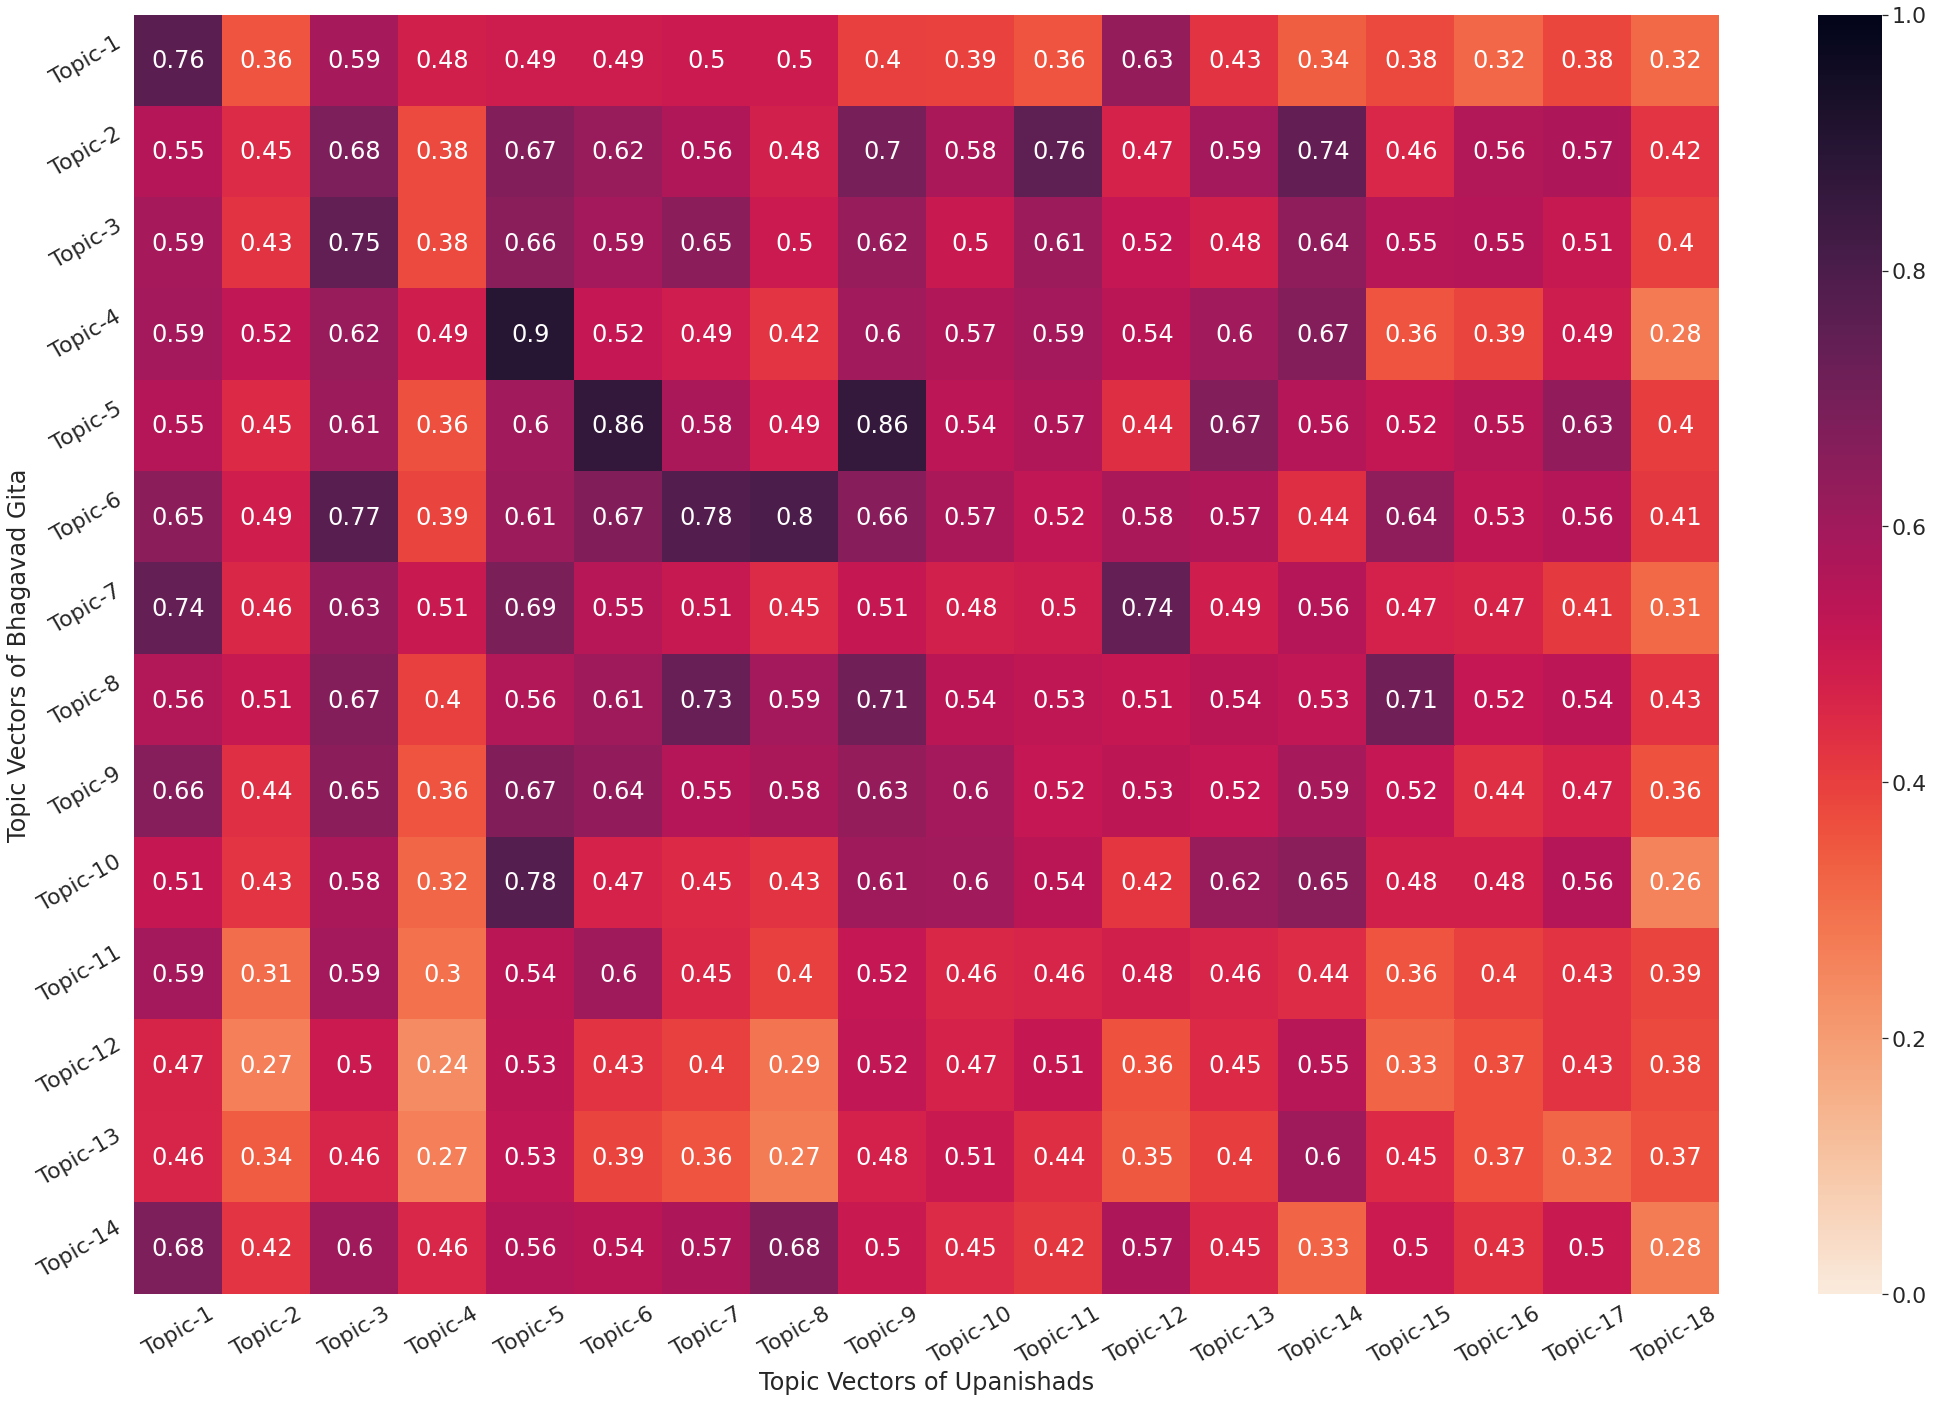

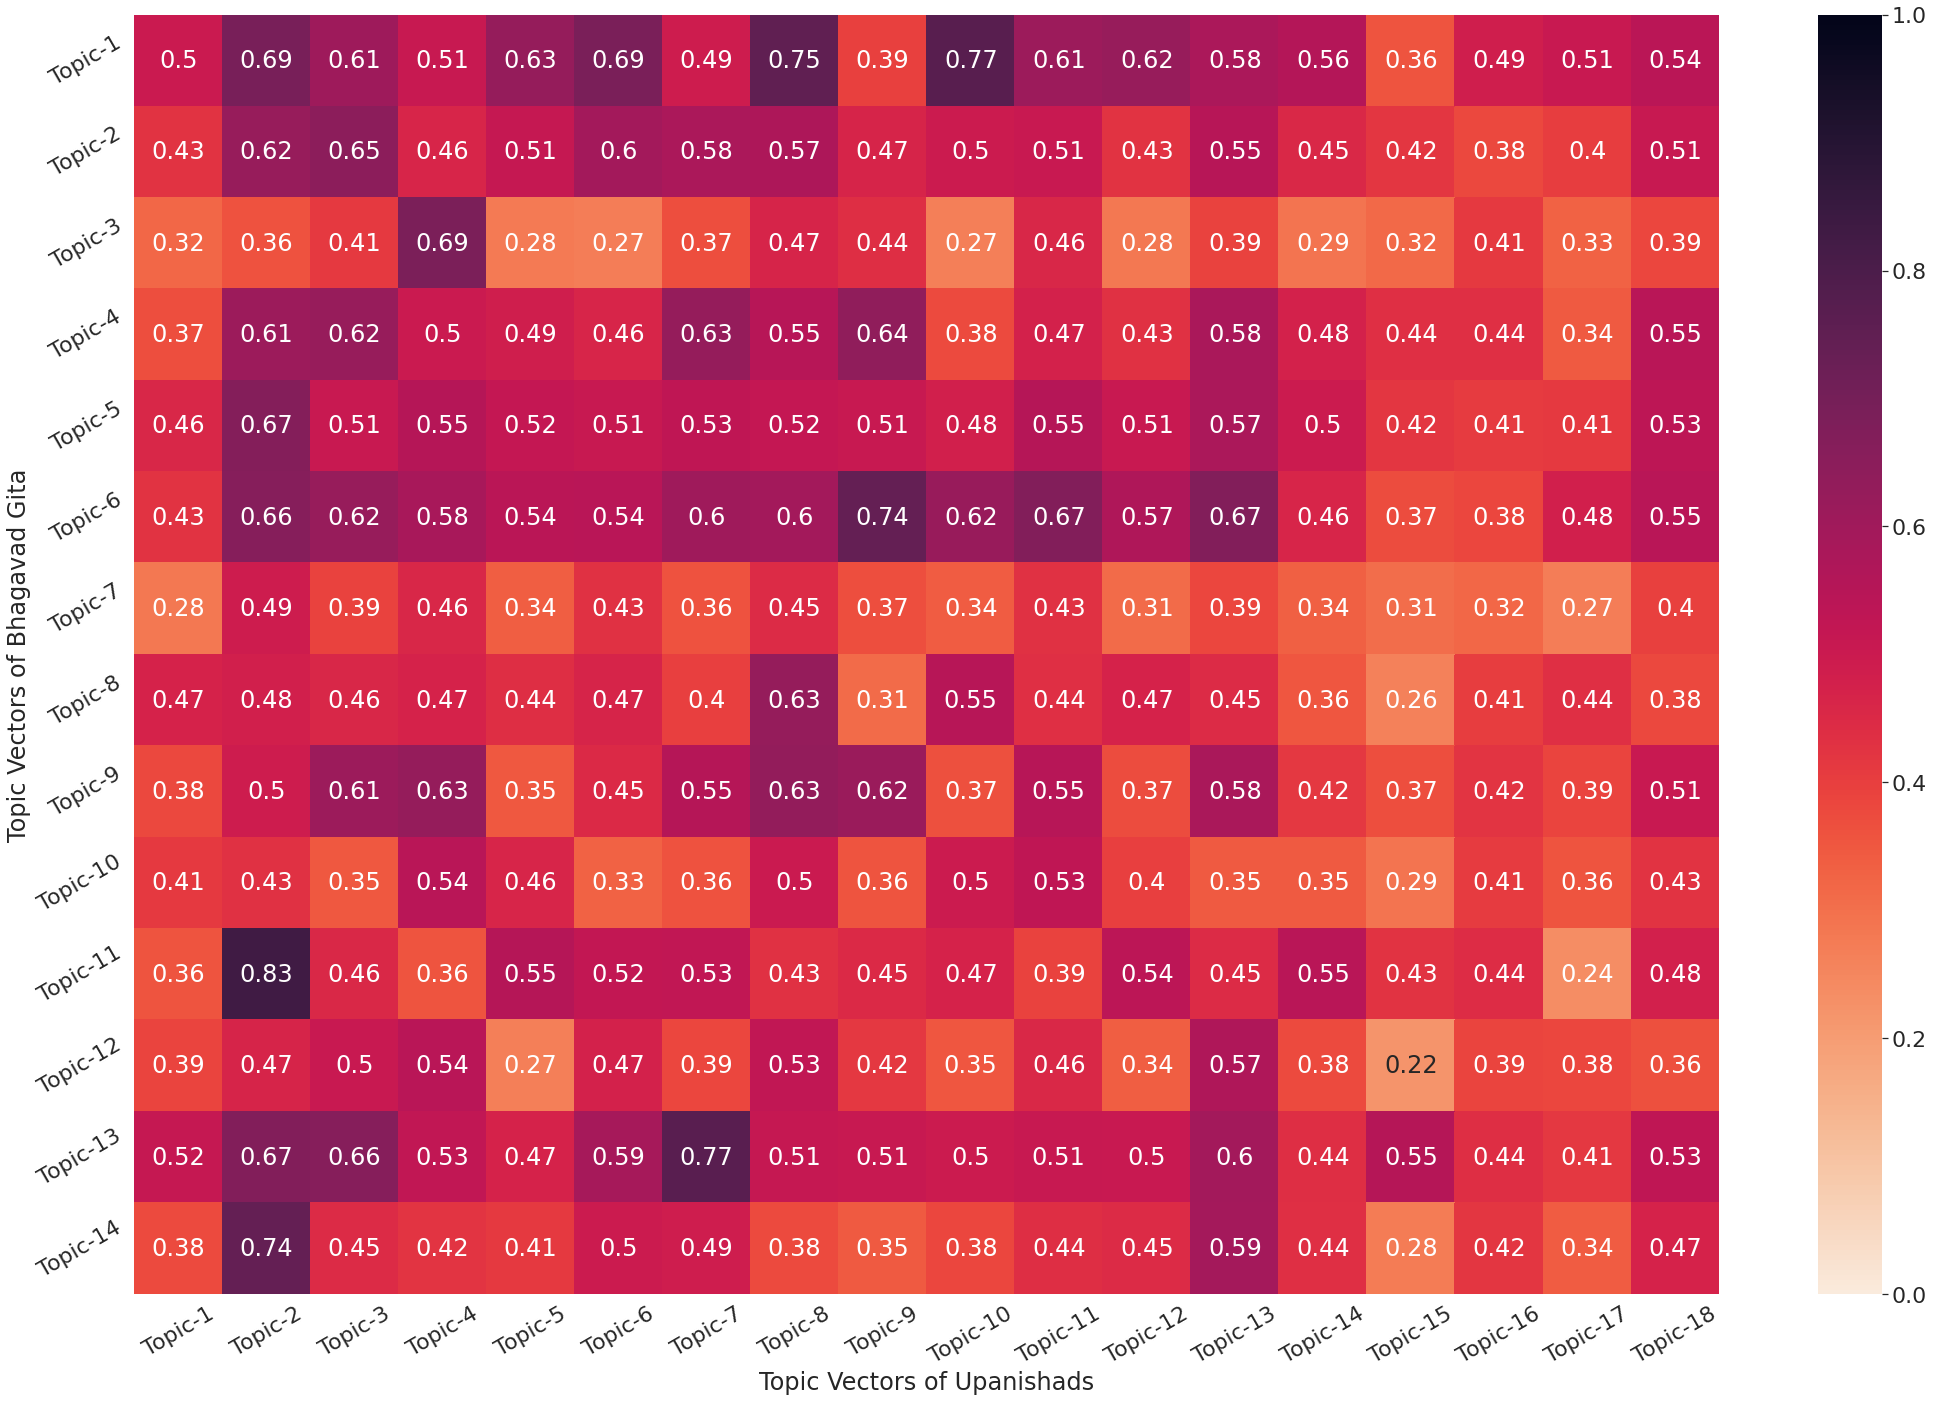

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def plot_similarity_matrix(model_upan, model_gita, filename = 'similarity_eaknath.pdf'):
  sns.set(font_scale=2)
  topic_vectors_upan = model_upan.topic_vectors
  topic_vectors_gita = model_gita.topic_vectors
  print(topic_vectors_upan.shape, topic_vectors_gita.shape)
  similarity_matrix = cosine_similarity(topic_vectors_gita, topic_vectors_upan)
  most_similar = similarity_matrix.argmax(axis=1)
  print("most similar topic ids of upanishads:")
  ms_value = similarity_matrix.max(axis=1)
  print('mean-similarity:{}'.format(ms_value.mean()))

  y_tick = ['Topic-{}'.format(x+1) for x in range(len(topic_vectors_gita))]
  x_tick = ['Topic-{}'.format(x+1) for x in range(len(topic_vectors_upan))]

  fig = plt.figure(figsize=(30,20))
  cmap = sns.cm.rocket_r
  hm = sns.heatmap(similarity_matrix, annot=True, vmin=0, vmax=1, xticklabels=True, yticklabels=True, cmap = cmap)
  _ = hm.set_xticklabels(x_tick, rotation=30)
  _ =  hm.set_yticklabels(y_tick, rotation=30)
  plt.ylabel("Topic Vectors of Bhagavad Gita")
  plt.xlabel("Topic Vectors of Upanishads") 
  plt.tight_layout()
  plt.savefig("/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/imgs/{}".format(filename), bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
plot_similarity_matrix(model_use_upan, model_use_gita, filename = 'similarity_eaknath_use.pdf')
plot_similarity_matrix(model_sbert_upan, model_sbert_gita, filename = 'similarity_eaknath_sbert.pdf')

In [ ]:
topic_use_upan, _, topic_nums = model_use_upan.get_topics()
topic_use_gita, _, _ = model_use_gita.get_topics()
topic_sbert_upan, _, _ = model_sbert_upan.get_topics()
topic_sbert_gita, _, _ = model_sbert_gita.get_topics()
print(topic_nums)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [ ]:
def save_similar_csv(model_upan, model_gita, file_name='similar_topics_use.csv'):
  most_similar_topics, ms_value = get_most_similar(model_upan, model_gita)

  topic_upan, _, topic_nums_upan = model_upan.get_topics()
  topic_gita, _, topic_nums_gita = model_gita.get_topics()

  similar_topics_from_upan = []
  for x in most_similar_topics:
    similar_topics_from_upan.append(topic_upan[x])
  print(len(similar_topics_from_upan))
  df = pd.DataFrame({"Topics of Gita":[','.join(list(x)) for x in topic_use_gita],
                     "Gita Topic ID": list(topic_nums_gita),
                     "Most Similar topics in Upanishads": [','.join(list(x)) for x in similar_topics_from_upan],
                     "Upanishads Topic ID": list(most_similar_topics),
                     "Similarity Score": list(ms_value)
                     }
                    )
  df.to_csv('/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/topics/{}'.format(file_name))
  df.to_csv(file_name)
  # df.head()
save_similar_csv(model_use_upan, model_use_gita, file_name='similar_topics_use.csv')
save_similar_csv(model_sbert_upan, model_sbert_gita, file_name='similar_topics_sbert.csv')

(18, 512) (14, 512)
[ 0 10  2  4  5  7  0  6  4  4  5 13 13  0]
[ 0  2  4  5  6  7 10 13]
0.72810763
[0.76331604 0.75715107 0.74826664 0.8960675  0.86438304 0.80309844
 0.74140835 0.7335342  0.6736479  0.77764297 0.60325974 0.5495623
 0.60201776 0.68015087]
14
(18, 512) (14, 512)
[ 9  2  3  8  1  8  1  7  7  3  1 12  6  1]
[ 1  2  3  6  7  8  9 12]
0.6675643
[0.7710278  0.6460279  0.68675184 0.63964885 0.6655644  0.73861974
 0.4933897  0.62705266 0.62904066 0.543212   0.82963383 0.56906164
 0.76673985 0.74012935]
14


## Ten Principal Upanishads

In [ ]:
def remove_stop_words(data):
  word_list = word_tokenize(data)
  # stops = set(stopwords.words("english"))
  # filtered_words = [word for word in word_list if word not in stops]
  return " ".join(word_list)

cleaned_docs = text.lower().split('\n')
cleaned_docs = [remove_stop_words(x) for x in cleaned_docs]
# cleaned_docs_tu = [x for x in cleaned_docs if len(x.strip().split(" "))>1]

cleaned_docs_tu = [x for x in cleaned_docs if len(x.strip().split(" "))>1]

In [ ]:
def get_all_words(doc_list):
  token_lists = []
  for doc in doc_list:
    token_lists.append(word_tokenize(doc))
  return token_lists

def process_doc(doc_lists):
  token_lists = get_all_words(doc_lists)
  dictionary = corpora.Dictionary(token_lists)
  # convert tokenized documents into a document-term matrix
  corpus = [dictionary.doc2bow(text) for text in token_lists]

  return token_lists, dictionary, corpus

def get_coherence(model, token_lists, corpus, dictionary, method = 'top2vec', measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if method == 'LDA':
        cm = CoherenceModel(model = model, texts=token_lists, corpus= corpus, dictionary = dictionary,
                            coherence=measure)
    else:
        topics = model.topic_words
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus= corpus, dictionary = dictionary,
                            coherence=measure)
    return cm.get_coherence()

In [ ]:
token_lists_tu, dictionary_tu, corpus_tu = process_doc(cleaned_docs_tu)

In [ ]:
# print(get_coherence(model_sbert_tu, token_lists_tu, corpus_tu, dictionary_tu), model_sbert_tu.get_num_topics())

In [ ]:
umap_args = {'n_neighbors': 15,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
#1710
hdbscan_args = {'min_cluster_size': 15,
                'min_samples':10,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
model_sbert_tu = TopicModel(documents = cleaned_docs_tu, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, hdbscan_args = hdbscan_args)
print("###Coherence SBERT ##### #No TOPIC SBERT")
print(get_coherence(model_sbert_tu, token_lists_tu, corpus_tu, dictionary_tu), model_sbert_tu.get_num_topics())

2022-01-30 20:05:00,511 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-30 20:05:00,635 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model
2022-01-30 20:05:04,736 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-30 20:06:45,726 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-30 20:06:51,811 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-01-30 20:06:

###Coherence SBERT ##### #No TOPIC SBERT
0.6857004609867209 18


In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 23,
                'min_samples':4,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
model_use_tu = TopicModel(documents= cleaned_docs_tu, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)

print("###Coherence USE ##### #No TOPIC USE")
print(get_coherence(model_use_tu, token_lists_tu, corpus_tu, dictionary_tu), model_use_tu.get_num_topics())

2022-01-30 21:06:29,699 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-30 21:06:29,831 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2022-01-30 21:06:33,696 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-30 21:06:40,185 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-30 21:06:45,690 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-

###Coherence USE ##### #No TOPIC USE
0.6595508831174755 18


In [ ]:
#40
#0.6823808326905068
# 19 - 0.689
# 3- 0.7665, (15,11)
# 26 - 6929 (10, 11)
# 25 - 6929 (12, 11)

(18, 512) (14, 512)
most similar topic ids of upanishads:
mean-similarity:0.7111028432846069
(18, 512) (14, 512)
most similar topic ids of upanishads:
mean-similarity:0.6183274388313293


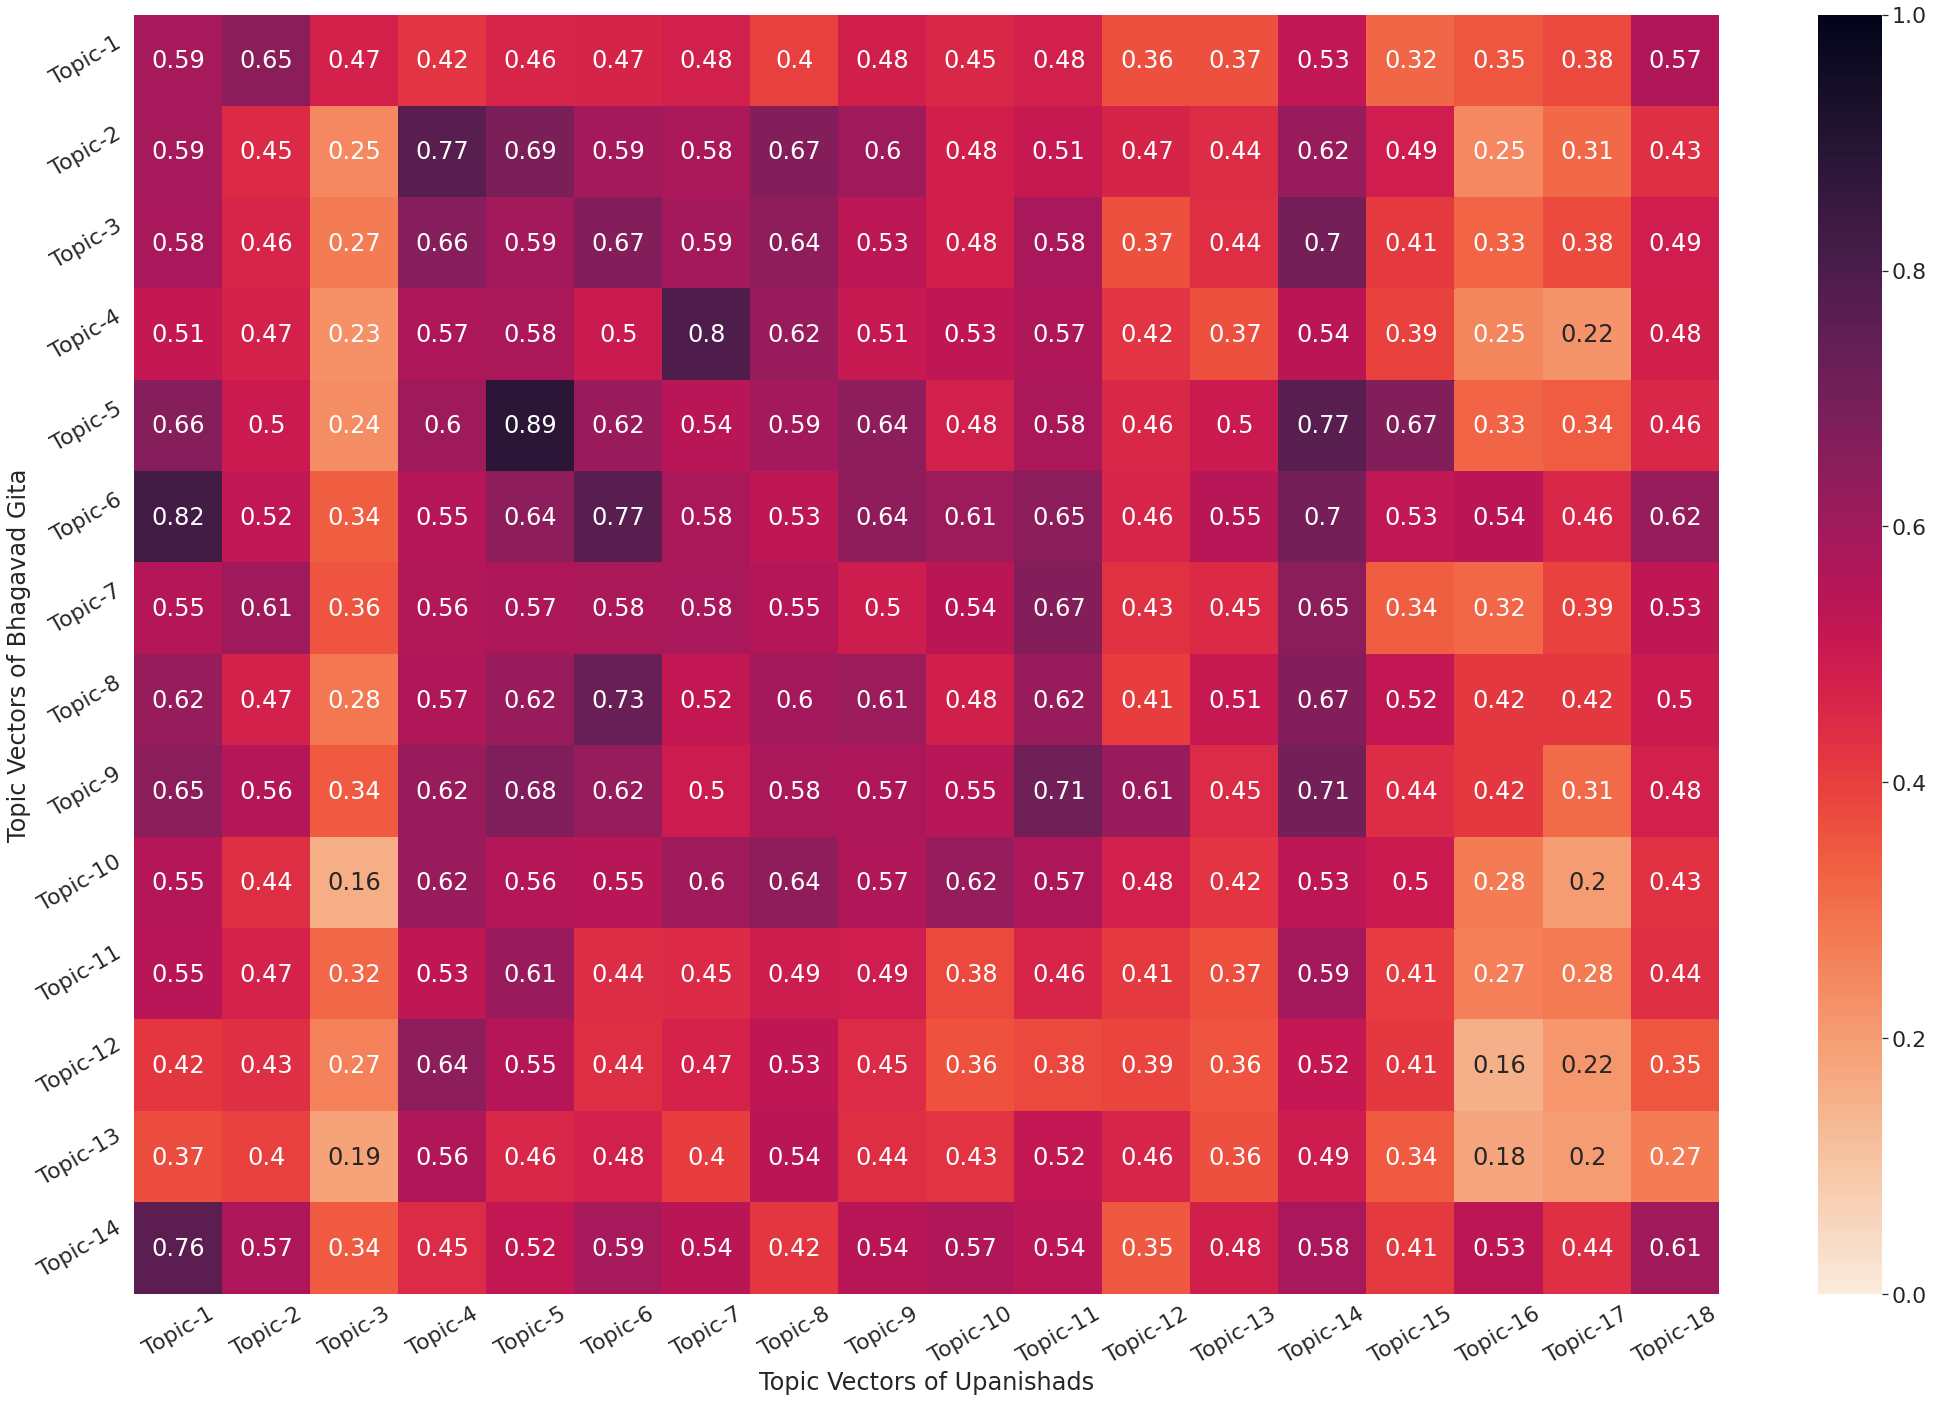

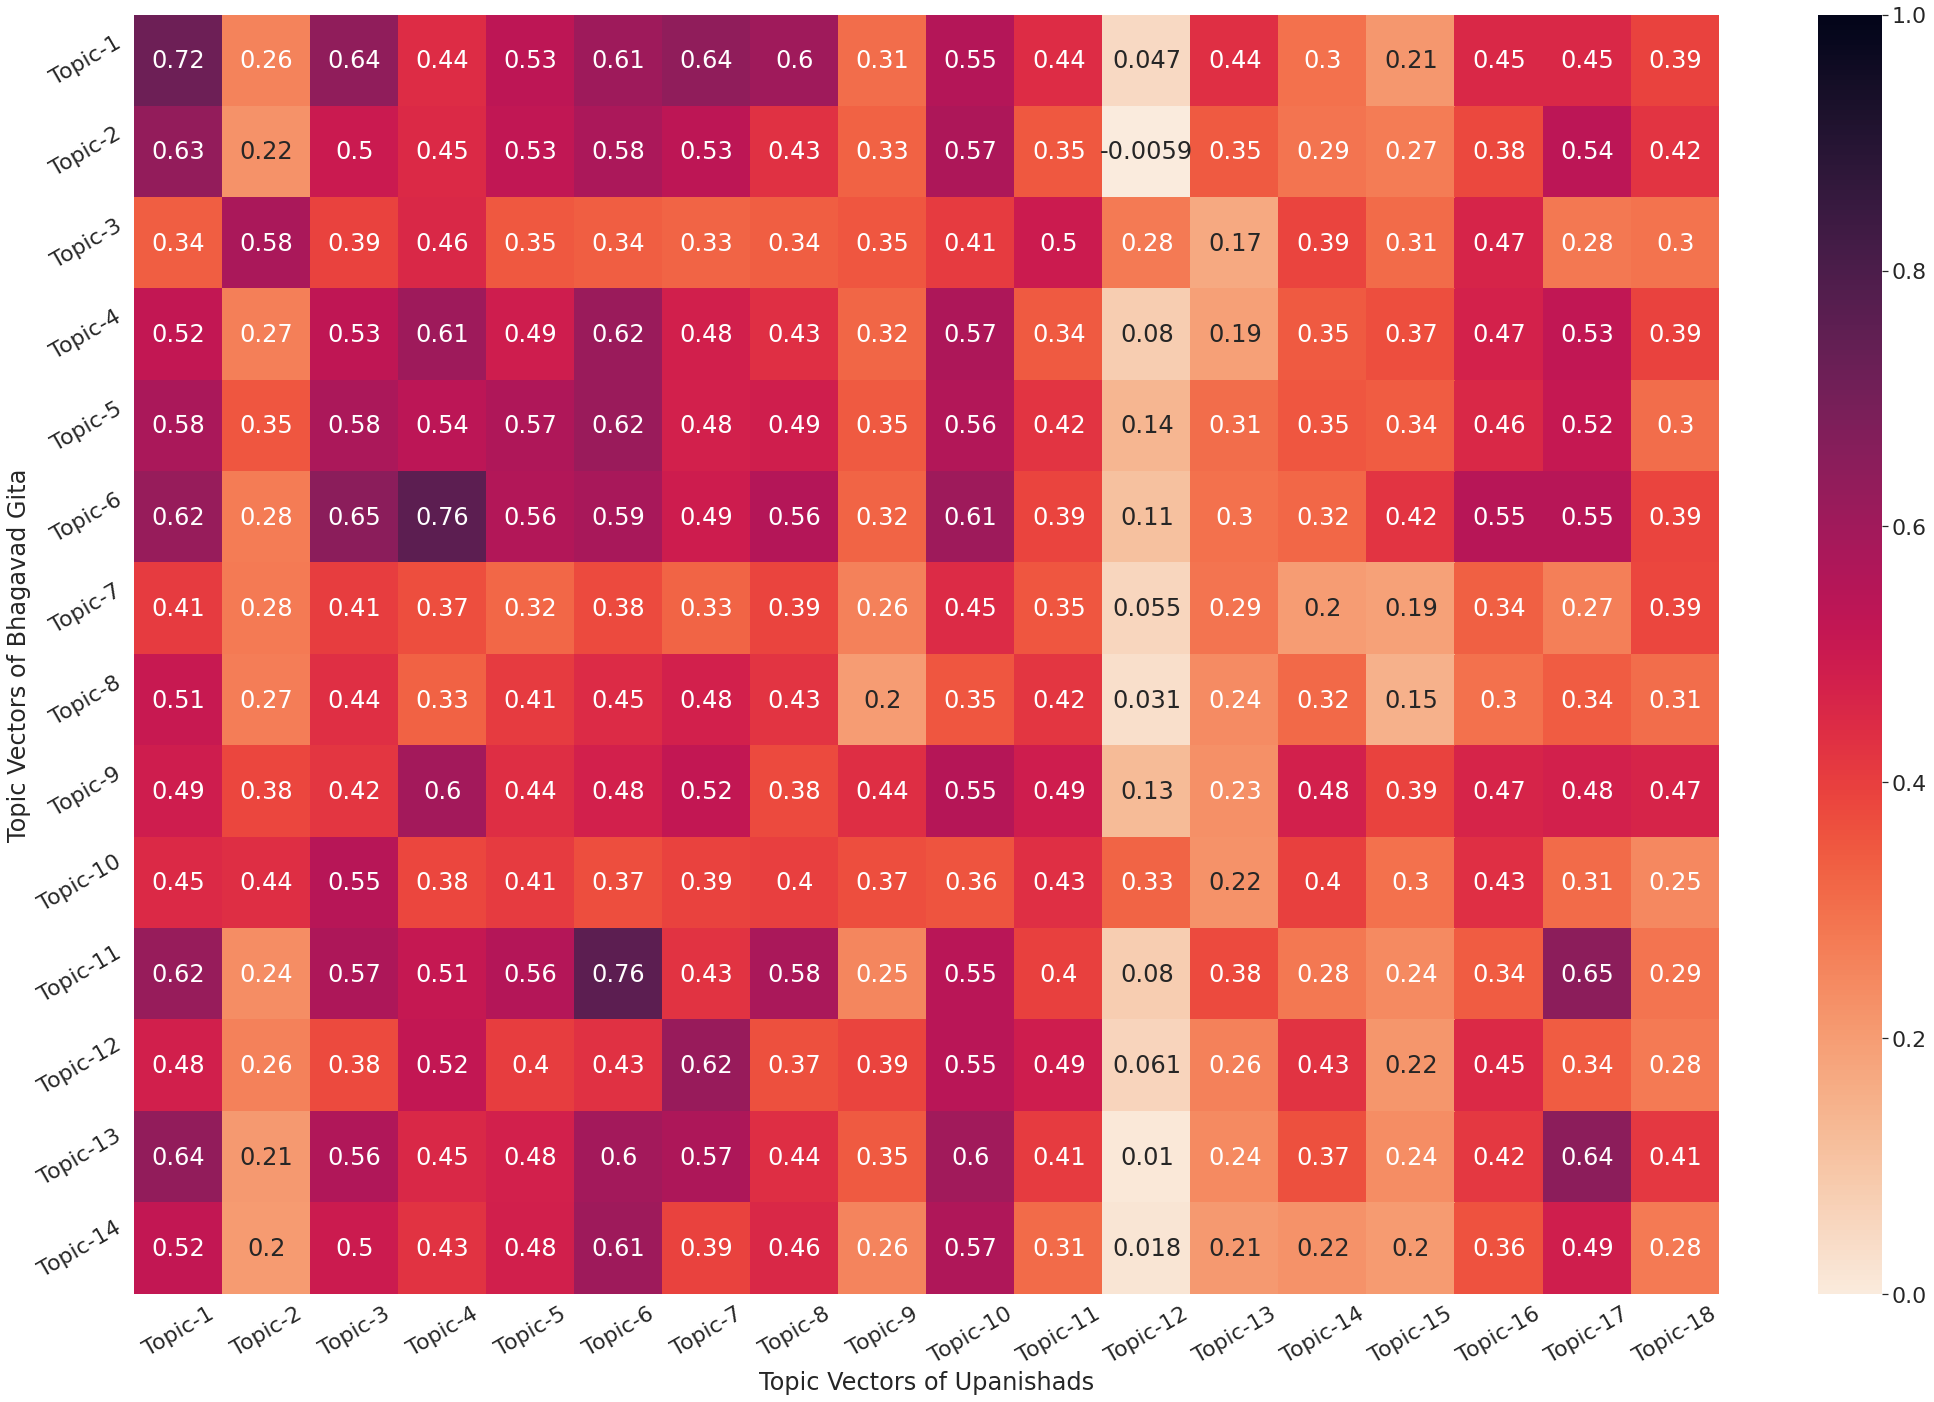

In [ ]:
plot_similarity_matrix(model_use_tu, model_use_gita, filename = 'similarity_tu_use.pdf')
plot_similarity_matrix(model_sbert_tu, model_sbert_gita, filename = 'similarity_tu_sbert.pdf')

In [ ]:
save_similar_csv(model_use_tu, model_use_gita, file_name='similar_topics_use_tu.csv')
save_similar_csv(model_sbert_tu, model_sbert_gita, file_name='similar_topics_sbert_tu.csv')
# similarity_matrix_tu.max(axis=0).mean()

(18, 512) (14, 512)
[ 1  3 13  6  4  0 10  5 10  7  4  3  3  0]
[ 0  1  3  4  5  6  7 10 13]
0.71110284
[0.6491545  0.77219033 0.7006115  0.79574203 0.8862426  0.8227978
 0.6654535  0.73275447 0.71437955 0.63692015 0.61370814 0.64440775
 0.56324613 0.75783193]
14
(18, 512) (14, 512)
[ 0  0  1  5  5  3  9  0  3  2  5  6 16  5]
[ 0  1  2  3  5  6  9 16]
0.61832744
[0.7189797  0.63175917 0.5810122  0.6156423  0.6164513  0.76114213
 0.44602618 0.50923705 0.5951734  0.55070627 0.760551   0.61957264
 0.6447277  0.605602  ]
14


In [ ]:
# topic_vectors_tu = model_use_tu.topic_vectors
# topic_vectors_gita = model_use_gita.topic_vectors
# print(topic_vectors_tu.shape, topic_vectors_gita.shape)
# similarity_matrix_tu = cosine_similarity(topic_vectors_gita, topic_vectors_tu)

# most_similar_tu = similarity_matrix_tu.argmax(axis=1)
# ms_value_tu = similarity_matrix_tu.max(axis=1)
# print('mean-similarity:{}'.format(ms_value_tu.mean()))

# y_tick = ['Topic-{}'.format(x+1) for x in range(len(topic_vectors_gita))]
# x_tick = ['Topic-{}'.format(x+1) for x in range(len(topic_vectors_tu))]

# fig = plt.figure(figsize=(30,20))
# cmap = sns.cm.rocket_r
# hm = sns.heatmap(similarity_matrix_tu, annot=True, vmin=0, vmax=1, xticklabels=True, yticklabels=True, cmap = cmap)
# _ = hm.set_xticklabels(x_tick, rotation=30)
# _ =  hm.set_yticklabels(y_tick, rotation=30)
# plt.ylabel("Topic Vectors of Bhagavad Gita")
# plt.xlabel("Topic Vectors of Upanishads") 
# plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/imgs/similarity_ten_upan.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
# def get_words(model, num_words = 20, num_topics = 10):
#     """
#     get n random words from each topics
#     """
#     reduced_flag = False
#     if model.get_num_topics() > num_topics:
#       reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_topics)
#       reduced_flag = True
    
#     topic_words, word_scores, topic_nums = model.get_topics(reduced=reduced_flag)

#     return topic_words[:,:num_words], word_scores[:,:num_words], topic_nums

In [ ]:
# words, _, _= get_words(model, 10, model.get_num_topics())
# words_gita, _, _ = get_words(model_gita, 10, model.get_num_topics())
# words_gita

In [ ]:
# words_gita[2]
# mstg = []
# for x in most_similar:
#   mstg.append(words_gita[x])
# len(mstg)
# df = pd.DataFrame({"Topics of Upanishads(top 10 words)":[','.join(list(x)) for x in words], "Most Similar topics in Gita": [','.join(list(x)) for x in mstg], "Similarity Score": list(ms_value)})
# df.head()
# df.iloc[1,1]

In [ ]:
# with open("my_table.tex", "w") as f:
#     f.write("\\begin{tabular}{" + " | ".join(["c"] * len(df.columns)) + "}\n")
#     for i, row in df.iterrows():
#         f.write(" & ".join([str(x) for x in row.values]) + " \\\\\n")
#     f.write("\\end{tabular}")

In [ ]:
# model_sbert_gita.generate_documents_plot(background_color="white")

In [ ]:
# topic_words, word_scores, topic_nums = model.get_topics()
# topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())

# for topic in topic_nums:
#     model.generate_topic_wordcloud(topic)

In [ ]:
# topic_words

## LDA Model

In [ ]:
num_topic_list = [5, 10, 15, 20, 25, 30, 35, 40]
#[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80]
npmi = []
for num_topics in num_topic_list:
  ldamodel_g = gensim.models.ldamodel.LdaModel(corpus_g, num_topics= num_topics, id2word = dictionary_g, passes=200, random_state = 42)
  npmi.append(get_coherence(ldamodel_g, token_lists_g, corpus_g, dictionary_g, method = 'LDA'))
  print(npmi)

[0.30234274699509955]
[0.30234274699509955, 0.3155939277703691]
[0.30234274699509955, 0.3155939277703691, 0.29075402670055583]
[0.30234274699509955, 0.3155939277703691, 0.29075402670055583, 0.3165243825156744]
[0.30234274699509955, 0.3155939277703691, 0.29075402670055583, 0.3165243825156744, 0.30269048517644526]
[0.30234274699509955, 0.3155939277703691, 0.29075402670055583, 0.3165243825156744, 0.30269048517644526, 0.28364654679888995]
[0.30234274699509955, 0.3155939277703691, 0.29075402670055583, 0.3165243825156744, 0.30269048517644526, 0.28364654679888995, 0.2721752426950352]
[0.30234274699509955, 0.3155939277703691, 0.29075402670055583, 0.3165243825156744, 0.30269048517644526, 0.28364654679888995, 0.2721752426950352, 0.30922418794043177]


In [ ]:
npmi

[0.30234274699509955,
 0.3155939277703691,
 0.29075402670055583,
 0.3165243825156744,
 0.30269048517644526,
 0.28364654679888995,
 0.2721752426950352,
 0.30922418794043177]

In [ ]:
num_topic_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80]
npmi_u = {}
for i, num_topics in enumerate(num_topic_list):
  ldamodel_u = gensim.models.ldamodel.LdaModel(corpus_u, num_topics= num_topics, id2word = dictionary_u, passes=200, random_state = 42)
  npmi_u[i] = get_coherence(ldamodel_u, token_lists_u, corpus_u, dictionary_u, method = 'LDA')
  print(npmi_u)

{0: 0.5285169245477339}
{0: 0.5285169245477339, 1: 0.5070016600581739}
{0: 0.5285169245477339, 1: 0.5070016600581739, 2: 0.5129224201640684}
{0: 0.5285169245477339, 1: 0.5070016600581739, 2: 0.5129224201640684, 3: 0.4837231204018309}
{0: 0.5285169245477339, 1: 0.5070016600581739, 2: 0.5129224201640684, 3: 0.4837231204018309, 4: 0.49459892253359933}
{0: 0.5285169245477339, 1: 0.5070016600581739, 2: 0.5129224201640684, 3: 0.4837231204018309, 4: 0.49459892253359933, 5: 0.4771184703282076}
{0: 0.5285169245477339, 1: 0.5070016600581739, 2: 0.5129224201640684, 3: 0.4837231204018309, 4: 0.49459892253359933, 5: 0.4771184703282076, 6: 0.48873937062008843}
{0: 0.5285169245477339, 1: 0.5070016600581739, 2: 0.5129224201640684, 3: 0.4837231204018309, 4: 0.49459892253359933, 5: 0.4771184703282076, 6: 0.48873937062008843, 7: 0.4603970958228203}
{0: 0.5285169245477339, 1: 0.5070016600581739, 2: 0.5129224201640684, 3: 0.4837231204018309, 4: 0.49459892253359933, 5: 0.4771184703282076, 6: 0.4887393706200

In [ ]:
npmi_u

{0: 0.5285169245477339,
 1: 0.5070016600581739,
 2: 0.5129224201640684,
 3: 0.4837231204018309,
 4: 0.49459892253359933,
 5: 0.4771184703282076,
 6: 0.48873937062008843,
 7: 0.4603970958228203,
 8: 0.4831463845203817,
 9: 0.4742656541878867,
 10: 0.454040748293705,
 11: 0.4575202679554725,
 12: 0.43642255156417764,
 13: 0.4685995882977597}

In [ ]:
ldamodel_u.print_topics(num_topics=6, num_words=25)

[(75,
  '0.116*"the" + 0.045*"and" + 0.045*"of" + 0.017*"in" + 0.015*"to" + 0.013*"path" + 0.012*"all" + 0.011*"a" + 0.009*"this" + 0.009*"his" + 0.009*"it" + 0.008*"self" + 0.008*"for" + 0.008*"understanding" + 0.008*"forms" + 0.007*"world" + 0.007*"can" + 0.007*"death" + 0.007*"spiritual" + 0.007*"sage" + 0.007*"are" + 0.006*"body" + 0.006*"with" + 0.006*"faith" + 0.006*"these"'),
 (74,
  '0.074*"he" + 0.064*"the" + 0.046*"is" + 0.043*"and" + 0.026*"no" + 0.021*"his" + 0.019*"state" + 0.017*"in" + 0.017*"of" + 0.016*"has" + 0.013*"that" + 0.013*"worlds" + 0.013*"all" + 0.011*"but" + 0.010*"from" + 0.010*"it" + 0.010*"fills" + 0.009*"makes" + 0.009*"know" + 0.009*"their" + 0.009*"impressions" + 0.009*"everyone" + 0.009*"life" + 0.008*"there" + 0.008*"or"'),
 (48,
  '0.054*"the" + 0.028*"is" + 0.025*"he" + 0.024*"and" + 0.020*"a" + 0.018*"of" + 0.017*"to" + 0.017*"that" + 0.015*"in" + 0.015*"from" + 0.014*"who" + 0.013*"him" + 0.013*"all" + 0.012*"when" + 0.012*"as" + 0.010*"faculties"

In [ ]:
ldamodel_g.print_topics(num_topics=6, num_words=25)

[(1,
  '0.037*"nor" + 0.031*"to" + 0.029*"i" + 0.028*"with" + 0.020*"you" + 0.020*"have" + 0.020*"me" + 0.017*"they" + 0.017*"will" + 0.015*"know" + 0.015*"has" + 0.015*"my" + 0.014*"a" + 0.014*"be" + 0.014*"seen" + 0.013*"that" + 0.012*"this" + 0.012*"which" + 0.012*"by" + 0.012*"those" + 0.011*"who" + 0.011*"doubts" + 0.010*"wisdom" + 0.010*"faith" + 0.009*"arjuna"'),
 (6,
  '0.045*"the" + 0.029*"by" + 0.025*"of" + 0.024*"and" + 0.023*"is" + 0.022*"self" + 0.019*"in" + 0.018*"a" + 0.016*"with" + 0.014*"it" + 0.013*"selfish" + 0.011*"desire" + 0.011*"ends" + 0.011*"they" + 0.010*"nor" + 0.009*"all" + 0.009*"are" + 0.009*"will" + 0.008*"mind" + 0.007*"that" + 0.007*"those" + 0.007*"brahma" + 0.007*"for" + 0.007*"dishonor" + 0.007*"elated"'),
 (35,
  '0.042*"the" + 0.032*"you" + 0.031*"and" + 0.030*"is" + 0.025*"a" + 0.024*"i" + 0.023*"of" + 0.021*"me" + 0.021*"to" + 0.016*"are" + 0.014*"all" + 0.013*"have" + 0.013*"can" + 0.011*"when" + 0.011*"it" + 0.011*"or" + 0.010*"krishna" + 0.010

## Universal Sentence Encoder

In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
model_gita_use = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)
print(model_gita_use.get_num_topics())

2021-11-14 12:32:54,721 - top2vec - INFO - Pre-processing documents for training
2021-11-14 12:32:54,795 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-multilingual/3, Total size: 266.88MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.
2021-11-14 12:33:03,801 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 12:33:08,207 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 12:33:11,783 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 12:33:11,810 - top2vec - 

14

In [ ]:
get_coherence(model_gita_use, token_lists_g, corpus_g, dictionary_g)

0.7255051661841652

In [ ]:
model_upan_use = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)
print(model_upan_use.get_num_topics())
print(get_coherence(model_upan_use, token_lists_u, corpus_u, dictionary_u))

2021-11-14 12:37:07,376 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 12:37:07,486 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 12:37:11,282 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 12:37:18,179 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 12:37:22,525 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 12:37:22,563 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


21
0.674850317093146


In [ ]:
topic_words, word_scores, topic_nums = model_upan_use.get_topics(model_upan_use.get_num_topics())
for topic in topic_nums:
  model_upan_use.generate_topic_wordcloud(topic)

In [ ]:
topic_words_gita_use, word_scores_gita_use, topic_nums_gita_use = model_gita_use.get_topics(model_gita_use.get_num_topics())
for topic in topic_nums_gita_use:
  model_gita_use.generate_topic_wordcloud(topic)

In [ ]:
topic_words_gita_use

## USE-UMAP-KMeans

In [ ]:
kmeans_args = {"n_clusters": 15, "init": "k-means++"}
model_upan_use_km = TopicModel(documents= cleaned_docs_all, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_upan_use_km.get_num_topics())
print(get_coherence(model_upan_use_km, token_lists_u, corpus_u, dictionary_u))

2021-11-14 15:17:27,786 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 15:17:27,904 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 15:17:38,648 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 15:17:45,460 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 15:17:49,813 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 15:17:52,111 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.6862064795710617


In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
kmeans_args = {"n_clusters": 20, 
               "init": "k-means++"
               }
model_upan_use_km = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_upan_use_km.get_num_topics())
print(get_coherence(model_upan_use_km, token_lists_u, corpus_u, dictionary_u))

2021-11-14 16:39:08,869 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 16:39:08,975 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 16:39:12,744 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 16:39:19,233 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 16:39:23,398 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 16:39:24,969 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


20
0.6636149817044875


In [ ]:
kmeans_args = {"n_clusters": 20, 
               "init": "k-means++"
               }
model_gita_use_km = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_gita_use_km.get_num_topics())
print(get_coherence(model_gita_use_km, token_lists_g, corpus_g, dictionary_g))

2021-11-14 16:56:05,947 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 16:56:06,000 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 16:56:10,329 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 16:56:13,601 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 16:56:17,024 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 16:56:18,219 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


20
0.718413861485851


In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
model_gita_use_km = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_gita_use_km.get_num_topics())
print(get_coherence(model_gita_use_km, token_lists_g, corpus_g, dictionary_g))

2021-11-14 16:56:26,679 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 16:56:26,737 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 16:56:30,878 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 16:56:34,287 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 16:56:37,687 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 16:56:38,763 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.7323957403105248


## SBERT-UMAP-Kmeans

In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
model_gita_sb_km = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_gita_sb_km.get_num_topics())
print(get_coherence(model_gita_sb_km, token_lists_g, corpus_g, dictionary_g))

2021-11-14 17:01:01,065 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 17:01:01,119 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2021-11-14 17:01:28,081 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 17:02:13,365 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 17:02:16,743 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 17:02:17,859 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.720611726701225


In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
model_upan_sb_km = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_upan_sb_km.get_num_topics())
print(get_coherence(model_upan_sb_km, token_lists_u, corpus_u, dictionary_u))

2021-11-14 17:03:11,067 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 17:03:11,177 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model
2021-11-14 17:03:14,929 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 17:04:53,104 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 17:04:57,282 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 17:04:58,543 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.6849348057339407


## Combined Docs

In [ ]:
combined_docs = cleaned_docs_all_upan+data_gita_list
print(len(combined_docs), len(data_gita_list), len(cleaned_docs_all_upan))

1573 699 874


In [ ]:
def get_embeddings_df_2d(model, num_reduced_topics = 10, sigma = None, random_state = 42 ):
    """
    2d plot the documents embedding
    """
    umap_args = {
      "n_neighbors": 15,
      "n_components": 2, # 5 -> 2 for plotting 
      "metric": "cosine",
      "random_state":random_state
      }
    if not sigma:
    	sigma = [3,3] #default value
    umap_data = umap.UMAP(**umap_args).fit_transform(model._get_document_vectors(norm=False))

    #get dataframe of the result 
    result = pd.DataFrame(umap_data, columns=['x_embeddings', 'y_embeddings'])
    result['Labels'] = np.array( ['Topic-'+ str(x+1) if x != -1 else 'outliers' for x in list(model.doc_top) ] )

    #### Hierarchical Topic Reduction ##########################
    new_label = []
    if model.get_num_topics() > num_reduced_topics:
      reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_reduced_topics)
      ######################################

      ###get new labels
      for top_doc in model.doc_top:
        for idx, reduced_list in enumerate(reduced_topic_lists):
          if top_doc in reduced_list:
            new_label.append("Topic-"+str(idx+1))
            break
      ##################################
      result["Labels"] = np.array(new_label)
    else:
      result["Labels"] = result['Labels']

    #remove outliers
    result = result[np.abs(result.x_embeddings-result.x_embeddings.mean()) <= (sigma[0]*result.x_embeddings.std())]
    result = result[np.abs(result.y_embeddings-result.y_embeddings.mean()) <= (sigma[1]*result.y_embeddings.std())]
    return result
# result = get_embeddings_df_2d(model_gita_use_km, sigma = [2.5, 2.5], num_reduced_topics = 10)
# result.shape()

In [ ]:
def plot2d_df(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('UMAP Embedding (dim = 1)')
    ax.set_ylabel('UMAP Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['Labels'])
    for idx, topics in enumerate(result.Labels.unique()):
        ax.scatter(x[result.Labels == topics],y[result.Labels == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.16, 0.77), title="Labels")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

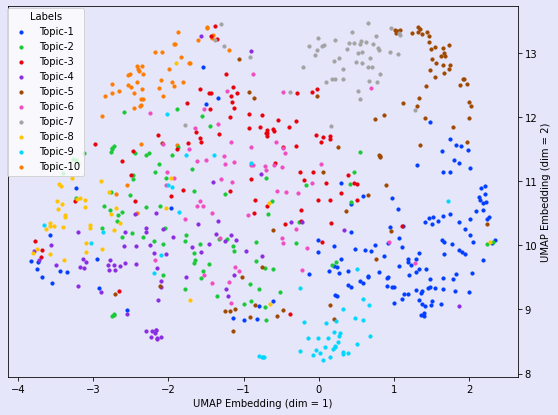

In [ ]:
plot2d_df(result = result,img_name = 'eknath_easwaran_gita_umap_km.pdf')

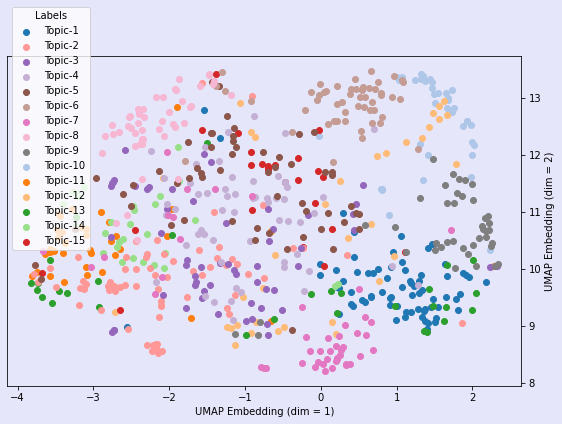

In [ ]:
result_t = get_embeddings_df_2d(model_gita_use_km, sigma = [2.5, 2.5], num_reduced_topics = 15)
# result.head()
plot2d_df(result = result_t, palet = 'tab20',img_name = 'eknath_easwaran_gita_umap_km.pdf')

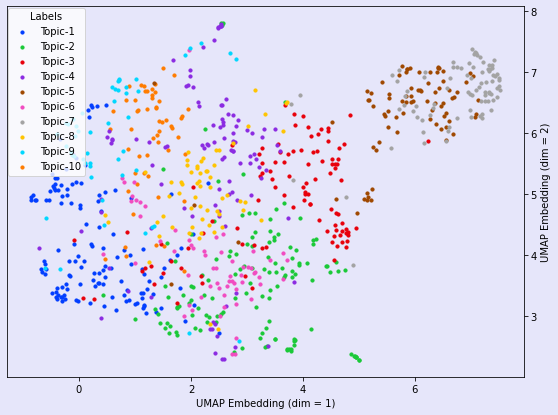

In [ ]:
result_upan = get_embeddings_df_2d(model_upan_use_km, sigma = [2.5, 2.5], num_reduced_topics = 10)
# result.head()
plot2d_df(result = result_upan, palet = 'bright',img_name = 'eknath_easwaran_upan_umap_km.pdf')

In [ ]:
token_lists_c, dictionary_c, corpus_c = process_doc(combined_docs)

In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
model_c_umap = TopicModel(documents = combined_docs, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_c_umap.get_num_topics())
print(get_coherence(model_c_umap, token_lists_c, corpus_c, dictionary_c))

2021-11-17 20:05:51,593 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2021-11-17 20:05:51,733 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2021-11-17 20:06:07,089 - top2vec - INFO - Creating joint document/word embedding
2021-11-17 20:08:33,403 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-11-17 20:08:48,337 - top2vec - INFO - Finding dense areas of documents
2021-11-17

15
0.691118928574904


In [ ]:
result_c_umap = get_embeddings_df_2d(model_c_umap, sigma = [2.5, 2.5], num_reduced_topics = 10)
(result_c_umap.head(), result_c_umap.shape)

(   x_embeddings  y_embeddings   Labels
 0     11.109902      8.122833  Topic-4
 1     10.920431      8.291782  Topic-4
 2     10.390152      8.465904  Topic-4
 3     10.654686      8.695951  Topic-4
 4     10.706587      8.403521  Topic-4, (1573, 3))

In [ ]:
a = ['The Upanishads' for x in range(874)]
b = ['The Bhagavad Gita' for x in range(699)]
result_c_umap['docs'] = a+b
result_c_umap.head(), result_c_umap.shape

(   x_embeddings  y_embeddings   Labels            docs
 0     11.109902      8.122833  Topic-4  The Upanishads
 1     10.920431      8.291782  Topic-4  The Upanishads
 2     10.390152      8.465904  Topic-4  The Upanishads
 3     10.654686      8.695951  Topic-4  The Upanishads
 4     10.706587      8.403521  Topic-4  The Upanishads, (1573, 4))

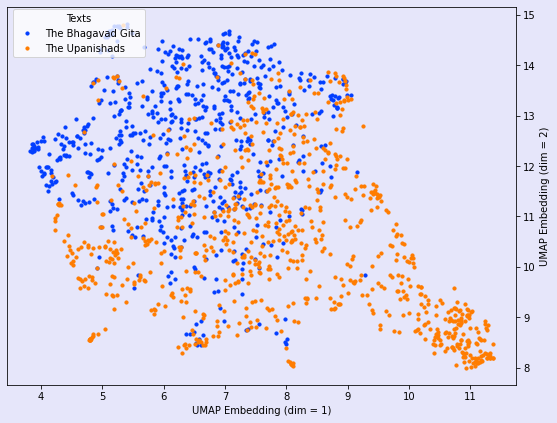

In [ ]:
def plot2d_text(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('UMAP Embedding (dim = 1)')
    ax.set_ylabel('UMAP Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['docs'])
    for idx, topics in enumerate(result.docs.unique()):
        ax.scatter(x[result.docs == topics],y[result.docs == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.28, 0.93), title="Texts")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
plot2d_text(result = result_c_umap,img_name = 'gita_in_upan.pdf')

## PCA embeddings

In [ ]:
def get_embeddings_df_2d_pca(model, num_reduced_topics = 10, sigma = None, random_state = 42 ):
    """
    2d plot the documents embedding
    """
    pca_args={"n_components": 2, 
          "svd_solver": "auto"}
    if not sigma:
    	sigma = [3,3] #default value
    umap_data = PCA(**pca_args).fit_transform(model._get_document_vectors(norm=False))

    #get dataframe of the result 
    result = pd.DataFrame(umap_data, columns=['x_embeddings', 'y_embeddings'])
    result['Labels'] = np.array( ['Topic-'+ str(x+1) if x != -1 else 'outliers' for x in list(model.doc_top) ] )

    #### Hierarchical Topic Reduction ##########################
    new_label = []
    if model.get_num_topics() > num_reduced_topics:
      reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_reduced_topics)
      ######################################

      ###get new labels
      for top_doc in model.doc_top:
        for idx, reduced_list in enumerate(reduced_topic_lists):
          if top_doc in reduced_list:
            new_label.append("Topic-"+str(idx+1))
            break
      ##################################
      result["Labels"] = np.array(new_label)
    else:
      result["Labels"] = result['Labels']

    #remove outliers
    result = result[np.abs(result.x_embeddings-result.x_embeddings.mean()) <= (sigma[0]*result.x_embeddings.std())]
    result = result[np.abs(result.y_embeddings-result.y_embeddings.mean()) <= (sigma[1]*result.y_embeddings.std())]
    return result
# result = get_embeddings_df_2d(model_gita_use_km, sigma = [2.5, 2.5], num_reduced_topics = 10)
def plot2d_df_pca(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('PCA Embedding (dim = 1)')
    ax.set_ylabel('PCA Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['Labels'])
    for idx, topics in enumerate(result.Labels.unique()):
        ax.scatter(x[result.Labels == topics],y[result.Labels == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.16, 0.77), title="Labels")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
def plot2d_text_pca(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('PCA Embedding (dim = 1)')
    ax.set_ylabel('PCA Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['docs'])
    for idx, topics in enumerate(result.docs.unique()):
        ax.scatter(x[result.docs == topics],y[result.docs == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.28, 0.93), title="Texts")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')


In [ ]:
combined_docs = cleaned_docs_all_upan + data_gita_list
print(len(combined_docs), len(data_gita_list), len(cleaned_docs_all_upan))

1573 699 874


In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
pca_args={"n_components": "mle", 
          "svd_solver": "full"}
model_c = TopicModel(documents = combined_docs, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', pca_args = pca_args, kmeans_args = kmeans_args)
print(model_c.get_num_topics())
print(get_coherence(model_c, token_lists_c, corpus_c, dictionary_c))

2021-11-17 19:35:53,404 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2021-11-17 19:35:53,613 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2021-11-17 19:36:17,699 - top2vec - INFO - Creating joint document/word embedding
2021-11-17 19:38:48,260 - top2vec - INFO - Creating lower dimension embedding of documents
2021-11-17 19:44:36,372 - top2vec - INFO - Finding dense areas of documents
2021-11-17 19:44:38,898 - top2vec - INFO - Finding topics


15
0.6937694569564558


In [ ]:
result_c = get_embeddings_df_2d_pca(model_c, sigma = [5, 5], num_reduced_topics = 10)

In [ ]:
result_c.shape

(1573, 3)

In [ ]:
a = ['The Upanishads' for x in range(874)]
b = ['The Bhagavad Gita' for x in range(699)]
result_c['docs'] = a+ b
result_c.head()

x_embeddings  y_embeddings   Labels            docs
0      0.509382     -0.136276  Topic-4  The Upanishads
1      0.463285     -0.028553  Topic-4  The Upanishads
2      0.544466     -0.083848  Topic-4  The Upanishads
3      0.420431      0.057026  Topic-4  The Upanishads
4      0.329127     -0.009985  Topic-4  The Upanishads

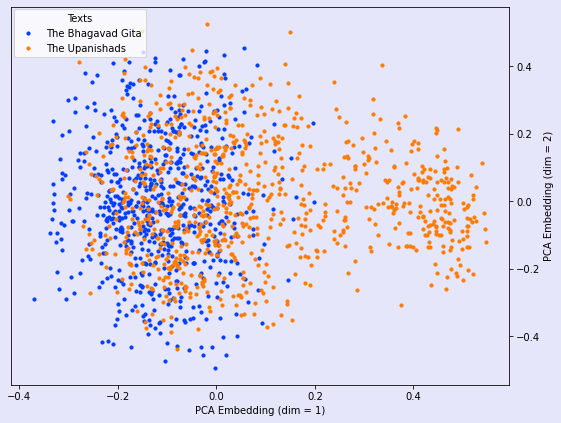

In [ ]:
plot2d_text_pca(result = result_c,img_name = 'gita_in_upan_pca.pdf')

## Tune the hyperparameters